In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Paths & Imports

In [30]:
######### LO ÚNICO QUE PUEDES CAMBIAR ##########
"""
GENERAL: Lo único que debes tener en cuenta antes de iniciar la ejecución es que
dentro de global_path deben estar: el notebook, la base de datos en la carpeta 
/data_2017 y la carpeta /common_code con todos los .py. => Para ejecutar el cuaderno, 
tienes que descargar mínimo las carpetas /common_code y /data_2017 y este notebook

SALIDAS: 
    - todas las salidas se van a guardar dentro de global_path en la carpeta
    model_AttConvLSTM_Deco_Class_GAP. Y dentro, en subcarpetas.

Para subir los resultados: puedes subir toda la carpeta model_AttConvLSTM_Deco_Class_GAP 
(la combinas con la actual), y ya con eso perfecto

"""
global_path = 'drive/My Drive/TFM/codeMelAtt' 
common_code = global_path + '/common_code'

In [31]:
import os
import sys
import warnings
warnings.filterwarnings('ignore') 

#sys.path.append(path)
sys.path.append(common_code)

In [32]:
import matplotlib.pyplot as plt
import random
from easydict import EasyDict
import numpy as np

# load and crate csv
import csv
import pandas as pd

# torch
import torch # version 1.4.0 (print(torch.__version__))
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.tensorboard import SummaryWriter

#import torchvision
import torchvision.utils as utils

In [33]:
# From common code 
!pip install munkres

from networks import *
from networks2 import *
from utilities import *
from loss import *
from data import *
from visualization import *
from train_aux import *
from train_aux import _worker_init_fn_


torch.manual_seed(0)

# Globals for execution

In [ ]:
total_train_images = 2000
# obtained in train: [2000. 2000. 1131.  126.  573.  116.] (imágenes en las que aparecen)
# píxeles en los que aparecen: [2.06147223e+09 1.12497618e+10 5.06278648e+08 2.65059870e+07 4.96865230e+07 9.14075300e+06]
# número total de píxeles: 1.38973733e+10
# # Para la base de datos pequeña:
# total_train_images = 83
# str_weights = [1, 1, total_train_images/59, total_train_images/30, total_train_images/30, total_train_images/32] # base de datos pequeña
str_weights = [1, 1, total_train_images/1131, total_train_images/126, total_train_images/573, total_train_images/116] # base de datos completa
str_weights = str_weights/np.sum(str_weights)

model = 'm3_complete'
total_epochs = 40
th_MAP = np.arange(0.5,0.8,0.1) # list of mean prec IoU score
batch_size = 8

# Best parameters
iou_w = 0.75
str_mul = 0.75
lr_attconv = 0.01

In [3]:
import numpy as np
str_weights = [1, 1, total_train_images/1131, total_train_images/126, total_train_images/573, total_train_images/116] # base de datos completa
str_weights = str_weights/np.sum(str_weights)
print(str_weights)

[0.02476894 0.02476894 0.04380007 0.39315779 0.08645355 0.42705071]


# Functions


### compute_AUC

In [35]:
import sklearn
def compute_AUC(y_mask, out_masks, y_classes, num_structs):
    """
    INPUTS:
        y_mask - list of b_s elements with shape [<=num_structs, N]
        out_masks - list of b_s elements with shape [<=num_structs, N]
        y_classes - list of b_s elements with shape [<=num_structs, ]
        threshold - integer between 0 and 1
    OUTPUTS:
        scores - [b_s, num_structs]
    """


    scores = np.zeros([len(y_mask),num_structs])

    for batch in range(len(y_mask)):
        k = 0
        counter = torch.zeros([num_structs]) 
        for structure in y_classes[batch]:
            y_mask_aux = y_mask[batch][k,:]

            scores[batch,structure] = scores[batch,structure] + sklearn.metrics.roc_auc_score(y_mask_aux.reshape(-1),out_masks[batch][k,:].reshape(-1))
            counter[structure] = counter[structure] + 1
            k += 1
        
        counter[counter==0] = 1
        scores[batch,:] = scores[batch,:]/counter

    return scores

### Algoritmos de asignación (Hungarian)

In [36]:
from random import randint
def allocation_algorithm(scores):
    # This algorithm allows classification of out_masks into repeated classes. If
    # two or more scores are the same, the class is selected randomly between the 
    # scores in conflict
    #
    # input:
    #   scores: [num_structures, T] - array of costs
    # output:
    #   indexes: [T,] - list of matched classes
    scores = np.array(scores)
    indexes = []
    cols = range(scores.shape[1])
    for col in cols:
        max_iou = np.min(scores[:,col])
        row = np.where(scores[:,col]==max_iou)[0]
        if row.shape[0]>1:
            possibilities = []
            for k in row:
                possibilities.append(k)
            
            selected = randint(0,len(possibilities)-1)
            row[0] = row[selected]

        indexes.append((row[0],col))

    return indexes

def limited_allocation_algorithm(scores):
    # This algorithm allows classification of out_masks into repeated classes. If
    # two or more scores are the same, the class is selected randomly between the 
    # scores in conflict
    #
    # input:
    #   scores: [num_structures, T] - array of costs
    # output:
    #   indexes: [T,] - list of matched classes
    scores = np.array(scores)
    indexes = []
    cols = range(scores.shape[1])
    for col in cols:
        max_iou = np.min(scores[:,col])
        row = np.where(scores[:,col]==max_iou)[0]
        if row.shape[0]>1:
            possibilities = []
            for k in row:
                possibilities.append(k)
            
            selected = randint(0,len(possibilities)-1)
            row[0] = row[selected]

        # Asignar coste máximo al mismo tipo de estructura para el instante siguiente 
        # para que no se seleccione la misma clase dos veces seguidas
        if col < np.max(cols):
            scores[row[0],col+1] = 1
        indexes.append((row[0],col))

    return indexes

In [37]:

# # get permutations of ground truth based on predictions (CPU computation)
#     y_true_p = y_true_p.permute(0,2,1) # torch.Size([b_s, T, N])
#     masks_all = [y_true_p,out_masks]
#     classes = [real_classes,out_classes]

#     # y_mask_perm - permuted GT masks - torch.Size([b_s, T, N])
#     # y_class_perm - permuted GT classes - torch.Size([b_s, T])
#     y_mask_perm, y_class_perm, _ = match(masks_all, classes, scores)

def match_no_rep(masks, classes, overlaps):
    """
    Args:
        masks - list containing [true_masks, pred_masks], both being [batch_size,T,N]
        classes - list containing [true_classes, pred_classes] with shape [batch_size,T,]
        overlaps - [batch_size,num_str,T] - matrix of costs between all pairs
    Returns:
        true_mask_cpu - [batch_size,T,N] permuted ground truth masks
        true_class_cpu - [batch_size,T,] permuted ground truth classes
        permute_indices - permutation indices used to sort the above
    """

    overlaps = (overlaps.data).cpu().numpy().tolist()
    m = Munkres() # clase del algoritmo hungarian

    true_mask, p_mask = masks
    true_class, p_class = classes

    # get true mask values to cpu as well
    true_mask_cpu = (true_mask.data).cpu().numpy()
    true_class_cpu = (true_class.data).cpu().numpy()

    true_mask_cpu2 = np.ones([p_mask.size(0),p_mask.size(1),p_mask.size(2)]) * (-1)
    true_class_cpu2 = np.ones([p_mask.size(0), p_mask.size(1)]) * (-1)
    true_mask_list, true_class_list = [], []
    # init matrix of permutations
    permute_indices = np.ones((true_mask.size(0),p_mask.size(1)),dtype=int) * (-1)
    num_structs, t = np.array(overlaps[0]).shape

    class_counter = np.zeros([num_structs,])
    # we will loop over all samples in batch (must apply munkres independently)
    for sample in range(p_mask.size(0)):
        # get the indexes of minimum cost
        # Rectify scores (eliminar máscaras que 'sobran', es decir, que no se van a asignar y asignar coste máximo a máscaras GT que sean todo ceros)
        overlaps[sample] = np.array(overlaps[sample])
        
        kept = 0
        for k in range(num_structs):
            s = np.sum(true_mask_cpu[sample,k,:])
            # Si la suma de todos los elemtos de la máscara es igual a 0 => máscara 'vacía'
            if s == 0:
                overlaps[sample][k] = 1 # se asigna el coste máximo a toda la fila de la máscara 'inexistente'
            else:
                kept += 1

        # Nos quedamos con tantas máscaras de salida como máscaras GT no-vacías tengamos
        if t>=kept:
            overlaps[sample] =  overlaps[sample][:,0:kept]

        overlaps[sample] = overlaps[sample].tolist()

        #indexes = allocation_algorithm(overlaps[sample])#= m.compute(overlaps[sample])
        indexes = m.compute(overlaps[sample]) # ejecución del hungarian

        for row, column in indexes:
            # put them in the permutation matrix
            permute_indices[sample,column] = row
        permute_aux = permute_indices[sample][permute_indices[sample]!=-1]
        # sort ground truth according to permutation
        true_mask_list.append(true_mask_cpu[sample,permute_aux,:])
        true_class_list.append(true_class_cpu[sample,permute_aux])

        # contador de aparición de clases
        class_counter[true_class_cpu[sample,permute_aux]] += 1

    # print(true_class_list)
    # true_class_cpu2 = true_class_cpu2.astype(np.int64)
    return true_mask_list, true_class_list, class_counter


# # get permutations of ground truth based on predictions (CPU computation)
#     y_true_p = y_true_p.permute(0,2,1) # torch.Size([b_s, T, N])
#     masks_all = [y_true_p,out_masks]
#     classes = [real_classes,out_classes]

#     # y_mask_perm - permuted GT masks - torch.Size([b_s, T, N])
#     # y_class_perm - permuted GT classes - torch.Size([b_s, T])
#     y_mask_perm, y_class_perm, _ = match(masks_all, classes, scores)

def match_combination(masks, classes, overlaps):
    """
    Args:
        masks - list containing [true_masks, pred_masks], both being [batch_size,T,N]
        classes - list containing [true_classes, pred_classes] with shape [batch_size,T,]
        overlaps - [batch_size,num_str,T] - matrix of costs between all pairs
    Returns:
        true_mask_cpu - [batch_size,T,N] permuted ground truth masks
        true_class_cpu - [batch_size,T,] permuted ground truth classes
        permute_indices - permutation indices used to sort the above
    """

    overlaps = (overlaps.data).cpu().numpy().tolist()
    m = Munkres() # clase del algoritmo hungarian

    true_mask, p_mask = masks
    true_class, p_class = classes

    # get true mask values to cpu as well
    true_mask_cpu = (true_mask.data).cpu().numpy()
    true_class_cpu = (true_class.data).cpu().numpy()

    true_mask_cpu2 = np.ones([p_mask.size(0),p_mask.size(1),p_mask.size(2)]) * (-1)
    true_class_cpu2 = np.ones([p_mask.size(0), p_mask.size(1)]) * (-1)
    true_mask_list, true_class_list = [], []
    # init matrix of permutations
    permute_indices = np.ones((true_mask.size(0),p_mask.size(1)),dtype=int) * (-1)
    num_structs, t = np.array(overlaps[0]).shape

    class_counter = np.zeros([num_structs,])
    # we will loop over all samples in batch (must apply munkres independently)
    for sample in range(p_mask.size(0)):
        # get the indexes of minimum cost
        # Rectify scores (eliminar máscaras que 'sobran', es decir, que no se van a asignar y asignar coste máximo a máscaras GT que sean todo ceros)
        overlaps[sample] = np.array(overlaps[sample])
        
        kept = 0
        for k in range(num_structs):
            s = np.sum(true_mask_cpu[sample,k,:])
            # Si la suma de todos los elemtos de la máscara es igual a 0 => máscara 'vacía'
            if s == 0:
                overlaps[sample][k] = 1 # se asigna el coste máximo a toda la fila de la máscara 'inexistente'
            else:
                kept += 1

        # Nos quedamos con tantas máscaras de salida como máscaras GT no-vacías tengamos
        if t>=kept:
            overlaps2 = overlaps[sample][:,kept::].tolist() # para aprovechar todos los instantes
            overlaps[sample] =  overlaps[sample][:,0:kept].tolist()

            indexes = m.compute(overlaps[sample]) # ejecución del hungarian
            indexes2 = m.compute(overlaps2)#allocation_algorithm(overlaps2)#= m.compute(overlaps[sample])
            for k in range(len(indexes2)):
                indexes.append((indexes2[k][0],indexes2[k][1]+kept))
            # print(indexes)
            # print(len(indexes))

        else:
            overlaps[sample] = overlaps[sample].tolist()
            indexes = m.compute(overlaps[sample]) # ejecución del hungarian
        

        for row, column in indexes:
            # put them in the permutation matrix
            permute_indices[sample,column] = row
        permute_aux = permute_indices[sample][permute_indices[sample]!=-1]
        # sort ground truth according to permutation
        true_mask_list.append(true_mask_cpu[sample,permute_aux,:])
        true_class_list.append(true_class_cpu[sample,permute_aux])

        # contador de aparición de clases
        for k in np.arange(0,num_structs):
            class_counter[k] += np.sum(true_class_cpu[sample,permute_aux]==k)
        # class_counter[true_class_cpu[sample,permute_aux]] += 1
        # print('true classes')
        # print(true_class_cpu[sample,permute_aux])
        # print(class_counter)

    # print(true_class_list)
    # true_class_cpu2 = true_class_cpu2.astype(np.int64)
    return true_mask_list, true_class_list, class_counter


def match_rep(masks, classes, overlaps):
    """
    Args:
        masks - list containing [true_masks, pred_masks], both being [batch_size,T,N]
        classes - list containing [true_classes, pred_classes] with shape [batch_size,T,]
        overlaps - [batch_size,num_str,T] - matrix of costs between all pairs
    Returns:
        true_mask_cpu - [batch_size,T,N] permuted ground truth masks
        true_class_cpu - [batch_size,T,] permuted ground truth classes
        permute_indices - permutation indices used to sort the above
    """

    overlaps = (overlaps.data).cpu().numpy().tolist()
    m = Munkres() # clase del algoritmo hungarian

    true_mask, p_mask = masks
    true_class, p_class = classes

    # get true mask values to cpu as well
    true_mask_cpu = (true_mask.data).cpu().numpy()
    true_class_cpu = (true_class.data).cpu().numpy()

    true_mask_cpu2 = np.ones([p_mask.size(0),p_mask.size(1),p_mask.size(2)]) * (-1)
    true_class_cpu2 = np.ones([p_mask.size(0), p_mask.size(1)]) * (-1)
    true_mask_list, true_class_list = [], []
    # init matrix of permutations
    permute_indices = np.ones((true_mask.size(0),p_mask.size(1)),dtype=int) * (-1)
    num_structs, t = np.array(overlaps[0]).shape

    class_counter = np.zeros([num_structs,])
    # we will loop over all samples in batch (must apply munkres independently)
    for sample in range(p_mask.size(0)):
        # get the indexes of minimum cost
        indexes = allocation_algorithm(overlaps[sample])#= m.compute(overlaps[sample])
        #indexes = m.compute(overlaps[sample]) # ejecución del hungarian

        for row, column in indexes:
            # put them in the permutation matrix
            permute_indices[sample,column] = row
        permute_aux = permute_indices[sample][permute_indices[sample]!=-1]
        # sort ground truth according to permutation
        true_mask_list.append(true_mask_cpu[sample,permute_aux,:])
        true_class_list.append(true_class_cpu[sample,permute_aux])

        # contador de aparición de clases
        class_counter[true_class_cpu[sample,permute_aux]] += 1

    # print(true_class_list)
    # true_class_cpu2 = true_class_cpu2.astype(np.int64)
    return true_mask_list, true_class_list, class_counter

def limited_match_rep(masks, classes, overlaps):
    """
    Args:
        masks - list containing [true_masks, pred_masks], both being [batch_size,T,N]
        classes - list containing [true_classes, pred_classes] with shape [batch_size,T,]
        overlaps - [batch_size,num_str,T] - matrix of costs between all pairs
    Returns:
        true_mask_cpu - [batch_size,T,N] permuted ground truth masks
        true_class_cpu - [batch_size,T,] permuted ground truth classes
        permute_indices - permutation indices used to sort the above
    """

    overlaps = (overlaps.data).cpu().numpy().tolist()
    m = Munkres() # clase del algoritmo hungarian

    true_mask, p_mask = masks
    true_class, p_class = classes

    # get true mask values to cpu as well
    true_mask_cpu = (true_mask.data).cpu().numpy()
    true_class_cpu = (true_class.data).cpu().numpy()

    true_mask_cpu2 = np.ones([p_mask.size(0),p_mask.size(1),p_mask.size(2)]) * (-1)
    true_class_cpu2 = np.ones([p_mask.size(0), p_mask.size(1)]) * (-1)
    true_mask_list, true_class_list = [], []
    # init matrix of permutations
    permute_indices = np.ones((true_mask.size(0),p_mask.size(1)),dtype=int) * (-1)
    num_structs, t = np.array(overlaps[0]).shape

    class_counter = np.zeros([num_structs,])
    # we will loop over all samples in batch (must apply munkres independently)
    for sample in range(p_mask.size(0)):
        # get the indexes of minimum cost
        indexes = limited_allocation_algorithm(overlaps[sample])#= m.compute(overlaps[sample])
        #indexes = m.compute(overlaps[sample]) # ejecución del hungarian

        for row, column in indexes:
            # put them in the permutation matrix
            permute_indices[sample,column] = row
        permute_aux = permute_indices[sample][permute_indices[sample]!=-1]
        # sort ground truth according to permutation
        true_mask_list.append(true_mask_cpu[sample,permute_aux,:])
        true_class_list.append(true_class_cpu[sample,permute_aux])

        # contador de aparición de clases
        class_counter[true_class_cpu[sample,permute_aux]] += 1

    # print(true_class_list)
    # true_class_cpu2 = true_class_cpu2.astype(np.int64)
    return true_mask_list, true_class_list, class_counter

### Compute loss structures

In [38]:
def obtain_pred_classes(out_classes):
    pred_classes = np.argmax(out_classes, axis=1)
    return pred_classes

#### Compute loss fuctions ####
import seaborn as sn
import pandas as pd
import sklearn
# At this moment, we are not using the stopping criterion (Loss_structures = Lm + Lc)
def compute_loss_structures_train(opt, masks, out_masks, real_classes, out_classes, mask_siou, class_crit, device):
    t = len(out_masks)
    num_structs = opt.num_structs
    b_s = masks.size(0)
    structures_weights = torch.tensor(opt.structures_weights).to(device)

    scores = torch.ones(b_s, num_structs,t).to(device)

    # GT masks
    y_true_p = masks.view(b_s,masks.size(1),masks.size(2)*masks.size(3)) # torch.Size([b_s, num_struct, N]) - N = dim*dim = 224*224
    y_true_p = y_true_p.permute(0,2,1) # torch.Size([b_s, N,  num_struct]) 

    for k in range(t):
        # repeat predicted mask as many times as elements in ground truth.
        # to compute iou against all ground truth elements at once
        y_pred_i = out_masks[k].view(out_masks[k].size(0),out_masks[k].size(1),out_masks[k].size(2)*out_masks[k].size(3)) # [bs, 1, N]
        y_pred_i = y_pred_i.repeat(1,masks.size(1),1) # torch.Size([b_s, num_structs, N])
        y_pred_i = y_pred_i.view(y_pred_i.size(0),y_pred_i.size(1),y_pred_i.size(2)) # torch.Size([b_s, num_structs, N]) 
        y_pred_i = y_pred_i.permute(0,2,1) # torch.Size([b_s, N, num_structs]) 
        
        c = softIoU(y_true_p, y_pred_i) 
        scores[:,:,k] = c.data

    out_masks1 = out_masks
    
    # concat all outputs into single tensor to compute the loss
    out_masks = torch.cat(out_masks,1).view(out_masks[0].size(0),len(out_masks), -1).to(device) # torch.Size([b_s, T, 224*224])
    out_classes = torch.cat(out_classes,0).view(out_classes[0].size(0),len(out_classes), -1).to(device) # torch.Size([b_s, T, num_structs])

    # get permutations of ground truth based on predictions (CPU computation)
    y_true_p = y_true_p.permute(0,2,1) # torch.Size([b_s, T, N])
    masks_all = [y_true_p,out_masks]
    classes = [real_classes,out_classes]

    # y_mask_perm - permuted GT masks - lists of b_s elements with shape [<=num_structs, N]
    # y_class_perm - permuted GT classes  - lists of b_s elements with shape [<=num_structs, ]
    # class_counter - counter of structure presence within the batch [num_structs,]
    y_mask_perm, y_class_perm, class_counter = match_no_rep(masks_all, classes, scores)

    loss_mask_iou, loss_class, loss_structures = 0, 0, 0
    # Para guardar las losses por estructura, sin promediar
    loss_mask_iou_imas, loss_class_imas = torch.zeros([num_structs,]).to(device), torch.zeros([num_structs,]).to(device)

    out_masks_aux_list = []
    class_counter = torch.tensor(class_counter).to(device)
    for batch in range(b_s):
        # move permuted ground truths back to GPU
        y_mask_perm_aux = Variable(torch.from_numpy(y_mask_perm[batch]), requires_grad=False).to(device) # torch.Size([b_s, T, N])
        y_class_perm_aux = Variable(torch.from_numpy(y_class_perm[batch]), requires_grad=False).to(device) # torch.Size([b_s, T])

        out_classes_aux = out_classes[batch,:,:]
        out_masks_aux = out_masks[batch, 0:y_class_perm_aux.size(0)]
        out_masks_aux_list.append(out_masks_aux.cpu().detach().numpy())

        GT_aux = y_class_perm_aux.cpu().detach().numpy()
        pred_classes_aux = obtain_pred_classes(out_classes_aux[0:y_class_perm_aux.size(0)].cpu().detach().numpy())
        if batch == 0:
            GT_classes = GT_aux
            pred_classes = pred_classes_aux
        else:
            GT_classes = np.hstack([GT_classes, GT_aux])
            pred_classes = np.hstack([pred_classes, pred_classes_aux])

        # Loss struct classification
        loss_class_aux = class_crit(y_class_perm_aux.view(-1,1),out_classes_aux.view(-1,out_classes_aux.size()[-1]))
        loss_class_imas[y_class_perm_aux] += loss_class_aux.squeeze()
        # print('\nClass loss')
        # print(GT_aux)
        # print(pred_classes_aux)
        # print(loss_class_aux.squeeze())

        # Loss mask IoU
        loss_mask_iou_aux = mask_siou(y_mask_perm_aux.view(-1,y_mask_perm_aux.size()[-1]),out_masks_aux.view(-1,out_masks_aux.size()[-1]))
        loss_mask_iou_imas[y_class_perm_aux] += loss_mask_iou_aux.squeeze()

        """
        # Prints & plots
        print('\nImage ' + str(batch) + ' in the batch')
        plt.figure(figsize=(15,60))
        for k in range(masks.size(1)):
            plt.subplot(1,masks.size(1),k+1)
            plt.imshow(masks[batch,k,:,:].cpu())
            plt.title('GT mask\nclass ' + str(k))
        plt.show()
        plt.figure(figsize=(15,60))
        for k in range(len(out_masks1)):
            plt.subplot(1,len(out_masks1),k+1)
            plt.imshow(out_masks1[k][batch,:,:,:].detach().cpu().squeeze())
            plt.title('Pred mask t=' + str(k))
        plt.show()

        titles = get_short_titles(num_structs)
        df_cm = pd.DataFrame(scores[batch,:,:].detach().cpu().numpy(), titles, range(len(out_masks1)))
        df_cm2 = pd.DataFrame(out_classes_aux.detach().cpu().numpy().T, titles, range(len(out_masks1)))
        
        print(scores[batch,:,:])
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        sn.heatmap(df_cm, annot=True, cmap="flare") # filas y columnas iguales si las máscaras de salida son las mismas en cada instante
        plt.xlabel('t')
        plt.ylabel('struct class')
        plt.title('1-softIoU')
        
        plt.subplot(1,2,2)
        sn.heatmap(df_cm2, annot=True, cmap="flare") # filas y columnas iguales si las máscaras de salida son las mismas en cada instante
        plt.xlabel('t')
        plt.ylabel('struct class')
        plt.title('predicted structures')
        plt.show()

        print('GT classes:')
        print(y_class_perm_aux)
        print('Loss structure class: ')
        print(loss_class_aux)
        print('Loss structure masks: ')
        print(loss_mask_iou_aux)
        """

    # Calcular número de estructuras diferentes presentes en el batch
    total_str = torch.sum(class_counter>0)

    # Suma de la división de la loss de cada estructura presente (por eso el class_counter!=0) entre las veces que ha aparecido en este batch. 
    # Después se divide entre el número de estructuras distintas
    loss_mask_iou = torch.sum(loss_mask_iou_imas[class_counter!=0]/class_counter[class_counter!=0])/total_str # (total_str*b_s)
    loss_class = torch.sum(loss_class_imas[class_counter!=0]/class_counter[class_counter!=0])/total_str # (total_str*b_s)
    # print('Losses per class')
    # print(loss_mask_iou_imas)
    # print('loss_after weighting')
    # print(loss_class_imas*structures_weights)
    # print('Class counter')
    # print(class_counter)
    # print('final losses')
    # print(loss_class)

    # total loss is the weighted sum of all terms
    loss_structures += opt.iou_weight * loss_mask_iou.to(device) + opt.class_weight*loss_class.to(device)

    return loss_structures, loss_mask_iou, loss_class, y_mask_perm, y_class_perm, out_masks_aux_list, GT_classes, pred_classes

def compute_loss_structures_eval(opt, masks, out_masks, real_classes, out_classes, mask_siou, class_crit, device):
    t = len(out_masks)
    num_structs = opt.num_structs
    structures_weights = torch.tensor(opt.structures_weights).to(device)
    b_s = masks.size(0)

    scores = torch.ones(b_s, num_structs,t).to(device)

    # GT masks
    y_true_p = masks.view(b_s,masks.size(1),masks.size(2)*masks.size(3)) # torch.Size([b_s, num_struct, N]) - N = dim*dim = 224*224
    y_true_p = y_true_p.permute(0,2,1) # torch.Size([b_s, N,  num_struct]) 

    for k in range(t):
        # repeat predicted mask as many times as elements in ground truth.
        # to compute iou against all ground truth elements at once
        y_pred_i = out_masks[k].view(out_masks[k].size(0),out_masks[k].size(1),out_masks[k].size(2)*out_masks[k].size(3)) # [bs, 1, N]
        y_pred_i = y_pred_i.repeat(1,masks.size(1),1) # torch.Size([b_s, num_structs, N])
        y_pred_i = y_pred_i.view(y_pred_i.size(0),y_pred_i.size(1),y_pred_i.size(2)) # torch.Size([b_s, num_structs, N]) 
        y_pred_i = y_pred_i.permute(0,2,1) # torch.Size([b_s, N, num_structs]) 
        
        c = softIoU(y_true_p, y_pred_i) 
        scores[:,:,k] = c.data

    out_masks1 = out_masks
    
    # concat all outputs into single tensor to compute the loss
    out_masks = torch.cat(out_masks,1).view(out_masks[0].size(0),len(out_masks), -1).to(device) # torch.Size([b_s, T, 224*224])
    out_classes = torch.cat(out_classes,0).view(out_classes[0].size(0),len(out_classes), -1).to(device) # torch.Size([b_s, T, num_structs])

    # get permutations of ground truth based on predictions (CPU computation)
    y_true_p = y_true_p.permute(0,2,1) # torch.Size([b_s, T, N])
    masks_all = [y_true_p,out_masks]
    classes = [real_classes,out_classes]

    # y_mask_perm - permuted GT masks - lists of b_s elements with shape [<=num_structs, N]
    # y_class_perm - permuted GT classes  - lists of b_s elements with shape [<=num_structs, ]
    # class_counter - counter of structure presence within the batch [num_structs,]
    y_mask_perm, y_class_perm, class_counter = match_rep(masks_all, classes, scores)

    loss_mask_iou, loss_class, loss_structures = 0, 0, 0
    # Para guardar las losses por estructura, sin promediar
    loss_mask_iou_imas, loss_class_imas = torch.zeros([num_structs,]).to(device), torch.zeros([num_structs,]).to(device)

    out_masks_aux_list = []
    mask_pred_list, y_pred_list = [], []
    class_counter = torch.tensor(class_counter).to(device)
    for batch in range(b_s):
        # move permuted ground truths back to GPU
        y_mask_pred_aux = y_true_p[batch,:,:].cpu().detach().numpy()
        y_mask_perm_aux = Variable(torch.from_numpy(y_mask_perm[batch]), requires_grad=False).to(device) # torch.Size([b_s, T, N])
        y_class_perm_aux = Variable(torch.from_numpy(y_class_perm[batch]), requires_grad=False).to(device) # torch.Size([b_s, T])

        out_classes_aux = out_classes[batch,:,:]
        out_masks_aux = out_masks[batch, 0:y_class_perm_aux.size(0)]
        out_masks_aux_list.append(out_masks_aux.cpu().detach().numpy())

        GT_aux = y_class_perm_aux.cpu().detach().numpy()
        y_pred_list.append(obtain_pred_classes(out_classes_aux[0:y_class_perm_aux.size(0)].cpu().detach().numpy()))
        mask_pred_list.append(y_mask_pred_aux[y_pred_list[-1],:])
        if batch == 0:
            GT_classes = GT_aux
            pred_classes = y_pred_list[-1]
        else:
            GT_classes = np.hstack([GT_classes, GT_aux])
            pred_classes = np.hstack([pred_classes, y_pred_list[-1]])

        # Loss struct classification
        loss_class_aux = class_crit(y_class_perm_aux.view(-1,1),out_classes_aux.view(-1,out_classes_aux.size()[-1]))
        loss_class_imas[y_class_perm_aux] += loss_class_aux.squeeze()

        # Loss mask IoU
        loss_mask_iou_aux = mask_siou(y_mask_perm_aux.view(-1,y_mask_perm_aux.size()[-1]),out_masks_aux.view(-1,out_masks_aux.size()[-1]))
        loss_mask_iou_imas[y_class_perm_aux] += loss_mask_iou_aux.squeeze()

        """
        # Prints & plots
        print('\nImage ' + str(batch) + ' in the batch')
        plt.figure(figsize=(15,60))
        for k in range(masks.size(1)):
            plt.subplot(1,masks.size(1),k+1)
            plt.imshow(masks[batch,k,:,:].cpu())
            plt.title('GT mask\nclass ' + str(k))
        plt.show()
        plt.figure(figsize=(15,60))
        for k in range(len(out_masks1)):
            plt.subplot(1,len(out_masks1),k+1)
            plt.imshow(out_masks1[k][batch,:,:,:].detach().cpu().squeeze())
            plt.title('Pred mask t=' + str(k))
        plt.show()

        titles = get_short_titles(num_structs)
        df_cm = pd.DataFrame(scores[batch,:,:].detach().cpu().numpy(), titles, range(len(out_masks1)))
        df_cm2 = pd.DataFrame(out_classes_aux.detach().cpu().numpy().T, titles, range(len(out_masks1)))
        
        print(scores[batch,:,:])
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        sn.heatmap(df_cm, annot=True, cmap="flare") # filas y columnas iguales si las máscaras de salida son las mismas en cada instante
        plt.xlabel('t')
        plt.ylabel('struct class')
        plt.title('1-softIoU')
        
        plt.subplot(1,2,2)
        sn.heatmap(df_cm2, annot=True, cmap="flare") # filas y columnas iguales si las máscaras de salida son las mismas en cada instante
        plt.xlabel('t')
        plt.ylabel('struct class')
        plt.title('predicted structures')
        plt.show()

        print('GT classes:')
        print(y_class_perm_aux)
        print('Loss structure class: ')
        print(loss_class_aux)
        print('Loss structure masks: ')
        print(loss_mask_iou_aux)
        """

    # Calcular número de estructuras diferentes presentes en el batch
    total_str = torch.sum(class_counter>0)

    # Suma de la división de la loss de cada estructura presente (por eso el class_counter!=0) entre las veces que ha aparecido en este batch. 
    # Después se divide entre el número de estructuras distintas
    loss_mask_iou = torch.sum(loss_mask_iou_imas[class_counter!=0]/class_counter[class_counter!=0])/total_str # (total_str*b_s)
    loss_class = torch.sum(loss_class_imas[class_counter!=0]/class_counter[class_counter!=0])/total_str # (total_str*b_s)
    # print('Losses per class')
    # print(loss_mask_iou_imas)
    # print('loss_after weighting')
    # print(loss_class_imas*structures_weights)
    # total loss is the weighted sum of all terms
    loss_structures += opt.iou_weight * loss_mask_iou.to(device) + opt.class_weight*loss_class.to(device)

    # return loss_structures, loss_mask_iou, loss_class, y_mask_perm, y_class_perm, out_masks_aux_list, GT_classes, pred_classes
    return loss_structures, loss_mask_iou, loss_class, mask_pred_list, y_pred_list, out_masks_aux_list, GT_classes, pred_classes

def compute_loss_structures_eval_test(opt, masks, out_masks, real_classes, out_classes, mask_siou, class_crit, device):
    t = len(out_masks)
    num_structs = opt.num_structs
    structures_weights = torch.tensor(opt.structures_weights).to(device)
    b_s = masks.size(0)

    scores = torch.ones(b_s, num_structs,t).to(device)

    # GT masks
    y_true_p = masks.view(b_s,masks.size(1),masks.size(2)*masks.size(3)) # torch.Size([b_s, num_struct, N]) - N = dim*dim = 224*224
    y_true_p = y_true_p.permute(0,2,1) # torch.Size([b_s, N,  num_struct]) 

    for k in range(t):
        # repeat predicted mask as many times as elements in ground truth.
        # to compute iou against all ground truth elements at once
        y_pred_i = out_masks[k].view(out_masks[k].size(0),out_masks[k].size(1),out_masks[k].size(2)*out_masks[k].size(3)) # [bs, 1, N]
        y_pred_i = y_pred_i.repeat(1,masks.size(1),1) # torch.Size([b_s, num_structs, N])
        y_pred_i = y_pred_i.view(y_pred_i.size(0),y_pred_i.size(1),y_pred_i.size(2)) # torch.Size([b_s, num_structs, N]) 
        y_pred_i = y_pred_i.permute(0,2,1) # torch.Size([b_s, N, num_structs]) 
        
        c = softIoU(y_true_p, y_pred_i) 
        scores[:,:,k] = c.data

    out_masks1 = out_masks
    
    # concat all outputs into single tensor to compute the loss
    out_masks = torch.cat(out_masks,1).view(out_masks[0].size(0),len(out_masks), -1).to(device) # torch.Size([b_s, T, 224*224])
    out_classes = torch.cat(out_classes,0).view(out_classes[0].size(0),len(out_classes), -1).to(device) # torch.Size([b_s, T, num_structs])

    # get permutations of ground truth based on predictions (CPU computation)
    y_true_p = y_true_p.permute(0,2,1) # torch.Size([b_s, T, N])
    masks_all = [y_true_p,out_masks]
    classes = [real_classes,out_classes]

    # y_mask_perm - permuted GT masks - lists of b_s elements with shape [<=num_structs, N]
    # y_class_perm - permuted GT classes  - lists of b_s elements with shape [<=num_structs, ]
    # class_counter - counter of structure presence within the batch [num_structs,]
    y_mask_perm, y_class_perm, class_counter = match_rep(masks_all, classes, scores)

    loss_mask_iou, loss_class, loss_structures = 0, 0, 0
    # Para guardar las losses por estructura, sin promediar
    loss_mask_iou_imas, loss_class_imas = torch.zeros([num_structs,]).to(device), torch.zeros([num_structs,]).to(device)

    out_masks_aux_list = []
    mask_pred_list, y_pred_list = [], []
    class_counter = torch.tensor(class_counter).to(device)
    GT_masks = []
    for batch in range(b_s):
        # move permuted ground truths back to GPU
        y_mask_pred_aux = y_true_p[batch,:,:].cpu().detach().numpy()
        y_mask_perm_aux = Variable(torch.from_numpy(y_mask_perm[batch]), requires_grad=False).to(device) # torch.Size([b_s, T, N])
        y_class_perm_aux = Variable(torch.from_numpy(y_class_perm[batch]), requires_grad=False).to(device) # torch.Size([b_s, T])

        out_classes_aux = out_classes[batch,:,:]
        out_masks_aux = out_masks[batch, 0:y_class_perm_aux.size(0)]
        out_masks_aux_list.append(out_masks_aux.cpu().detach().numpy())

        GT_aux = y_class_perm_aux.cpu().detach().numpy()
        # list of predicted classes
        y_pred_list.append(obtain_pred_classes(out_classes_aux[0:y_class_perm_aux.size(0)].cpu().detach().numpy()))

        # list of GT masks permuted based on the pred class
        mask_pred_list.append(y_mask_pred_aux[y_pred_list[-1],:])
        # list of GT masks permuted based the hungarian
        GT_masks.append(y_mask_pred_aux)

        if batch == 0:
            GT_classes = GT_aux
            pred_classes = y_pred_list[-1]
        else:
            GT_classes = np.hstack([GT_classes, GT_aux])
            pred_classes = np.hstack([pred_classes, y_pred_list[-1]])

        # Loss struct classification
        loss_class_aux = class_crit(y_class_perm_aux.view(-1,1),out_classes_aux.view(-1,out_classes_aux.size()[-1]))
        loss_class_imas[y_class_perm_aux] += loss_class_aux.squeeze()

        # Loss mask IoU
        loss_mask_iou_aux = mask_siou(y_mask_perm_aux.view(-1,y_mask_perm_aux.size()[-1]),out_masks_aux.view(-1,out_masks_aux.size()[-1]))
        loss_mask_iou_imas[y_class_perm_aux] += loss_mask_iou_aux.squeeze()

        """
        # Prints & plots
        print('\nImage ' + str(batch) + ' in the batch')
        plt.figure(figsize=(15,60))
        for k in range(masks.size(1)):
            plt.subplot(1,masks.size(1),k+1)
            plt.imshow(masks[batch,k,:,:].cpu())
            plt.title('GT mask\nclass ' + str(k))
        plt.show()
        plt.figure(figsize=(15,60))
        for k in range(len(out_masks1)):
            plt.subplot(1,len(out_masks1),k+1)
            plt.imshow(out_masks1[k][batch,:,:,:].detach().cpu().squeeze())
            plt.title('Pred mask t=' + str(k))
        plt.show()

        titles = get_short_titles(num_structs)
        df_cm = pd.DataFrame(scores[batch,:,:].detach().cpu().numpy(), titles, range(len(out_masks1)))
        df_cm2 = pd.DataFrame(out_classes_aux.detach().cpu().numpy().T, titles, range(len(out_masks1)))
        
        print(scores[batch,:,:])
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        sn.heatmap(df_cm, annot=True, cmap="flare") # filas y columnas iguales si las máscaras de salida son las mismas en cada instante
        plt.xlabel('t')
        plt.ylabel('struct class')
        plt.title('1-softIoU')
        
        plt.subplot(1,2,2)
        sn.heatmap(df_cm2, annot=True, cmap="flare") # filas y columnas iguales si las máscaras de salida son las mismas en cada instante
        plt.xlabel('t')
        plt.ylabel('struct class')
        plt.title('predicted structures')
        plt.show()

        print('GT classes:')
        print(y_class_perm_aux)
        print('Loss structure class: ')
        print(loss_class_aux)
        print('Loss structure masks: ')
        print(loss_mask_iou_aux)
        """

    # Calcular número de estructuras diferentes presentes en el batch
    total_str = torch.sum(class_counter>0)

    # Suma de la división de la loss de cada estructura presente (por eso el class_counter!=0) entre las veces que ha aparecido en este batch. 
    # Después se divide entre el número de estructuras distintas
    loss_mask_iou = torch.sum((loss_mask_iou_imas[class_counter!=0]/class_counter[class_counter!=0])*structures_weights[class_counter!=0])/total_str
    loss_class = torch.sum((loss_class_imas[class_counter!=0]/class_counter[class_counter!=0])*structures_weights[class_counter!=0])/total_str
    # print('Losses per class')
    # print(loss_mask_iou_imas)
    # print('loss_after weighting')
    # print(loss_class_imas*structures_weights)
    # total loss is the weighted sum of all terms
    loss_structures += opt.iou_weight * loss_mask_iou.to(device) + opt.class_weight*loss_class.to(device)

    # return loss_structures, loss_mask_iou, loss_class, y_mask_perm, y_class_perm, out_masks_aux_list, GT_classes, pred_classes
    return loss_structures, loss_mask_iou, loss_class, mask_pred_list, GT_masks, y_pred_list, out_masks_aux_list, GT_classes, pred_classes, out_masks, y_mask_perm


# Test function in case we don't have the GT
def pred_classes_test(opt, masks, out_masks, out_classes, mask_siou, class_crit, device):
    T = opt.t
    num_structs = opt.num_structs

    # concat all outputs into single tensor to compute the loss
    out_masks = torch.cat(out_masks,1).view(out_masks[0].size(0),len(out_masks), -1).to(device) # torch.Size([b_s, T, 224*224])
    out_classes = torch.cat(out_classes,0).view(out_classes[0].size(0),len(out_classes), -1).to(device) # torch.Size([b_s, T, num_structs])
    b_s= out_masks.size(0)
    
    out_masks_list = []
    class_counter =  torch.zeros([num_structs,]).to(device)
    # Para cada imagen del batch
    for k in range(b_s):
        class_scores = out_classes[k,:,:]
        out_masks_list.append(out_masks[k].cpu().detach().numpy())

        y_pred_class = obtain_pred_classes(class_scores.cpu().detach().numpy())
        class_counter[np.int64(y_pred_class[k])] += 1

    return out_masks_list, y_pred_class

### train_deco_class

In [39]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_ids = [0]

def train_fun(opt):
    torch.cuda.empty_cache()

    if opt.enable_classifier == 1:
        if opt.enable_decoder == 1:
            train_deco_class(opt)
        else:
            train_class(opt)
    elif opt.enable_decoder == 1:
        train_deco()
    else:
        print('Error: Decoder and classifier disabled')
        return -1
        
def train_deco_class(opt):
    torch.cuda.empty_cache()

    ##### Create the arquitecture and load directories #####
    path, out_files, net = get_dirs_and_net(opt, device)

    ##### Load data #####
    print('\nloading the dataset ...')
    db_dir, train_file, trainloader, val_file, valloader = preprocess_data_train(opt, path, opt.data_loading)

    print('done\n')

    ############### Load models ###############
    ##### Choose the objective function or criterion #####
    criterion = choose_criterion(0).to(device) # opt.criterion) # Focal loss for diagnose

    mask_siou = softIoULoss().to(device)                                               # Segmentation loss
    class_crit = MaskedNLLLoss(balance_weight=None).to(device)                         # Structure classification loss (class_xentropy) (balance_weight=torch.tensor([1,1,10,10,10,10]))

    ##### Load checkpoints #####
    if opt.first_epoch != 0:
        checkpoint_lists, checkpoint = load_checkpoints(opt,out_files)
        net.load_state_dict(checkpoint['state_dict'])
    else:
        checkpoint_lists, checkpoint = None, None
        
    ##### Moving models to GPU #####
    print('\nmoving models to GPU ...')
    model = nn.DataParallel(net, device_ids=device_ids).to(device)
    print('done\n')

    if opt.frozen == True:
        print('\nFreeze BN layers')
        for module in model.modules():
            # print(module)
            if isinstance(module, nn.BatchNorm2d):
                if hasattr(module, 'weight'):
                    module.weight.requires_grad_(False)
                if hasattr(module, 'bias'):
                    module.bias.requires_grad_(False)
                module.eval()

    ##### Load or create optimizer #####
    if opt.enable_multi_lr == 1:
        optimizer = load_optimizer_multiple_lr(opt, model, checkpoint)
    else:
        optimizer, scheduler_2 = load_or_create_optimizer_and_scheduler(opt, model, checkpoint)

    ##### Load scores and losses #####
    if opt.first_epoch != 0:
        # Load lists
        loss_train, loss_val_list = checkpoint_lists['loss_train'][:opt.first_epoch], checkpoint_lists['loss_val_list'][:opt.first_epoch]
        loss_train_class, loss_val_class = checkpoint_lists['loss_train_class'][:opt.first_epoch], checkpoint_lists['loss_val_class'][:opt.first_epoch]
        loss_train_str, loss_val_str = checkpoint_lists['loss_train_str'][:opt.first_epoch], checkpoint_lists['loss_val_str'][:opt.first_epoch]
        loss_train_str_mask, loss_train_str_class = checkpoint_lists['loss_train_str_mask'][:opt.first_epoch], checkpoint_lists['loss_train_str_class'][:opt.first_epoch]
        loss_val_str_mask, loss_val_str_class = checkpoint_lists['loss_val_str_mask'][:opt.first_epoch], checkpoint_lists['loss_val_str_class'][:opt.first_epoch]
        step_list = checkpoint_lists['step_list'][:opt.first_epoch]
        
        step = step_list[-1]
        
        # Decoder
        jaccard_scores_train = torch.zeros([opt.epochs, opt.num_structs])
        jaccard_scores_train[:opt.first_epoch,:] = checkpoint_lists['jaccard_scores_train'][:opt.first_epoch,:]
        jaccard_scores_val = torch.zeros([opt.epochs, opt.num_structs])
        jaccard_scores_val[:opt.first_epoch,:] = checkpoint_lists['jaccard_scores_val'][:opt.first_epoch,:]
        avg_prec_scores_train = torch.zeros([opt.epochs])
        avg_prec_scores_train[:opt.first_epoch] = checkpoint_lists['avg_prec_scores_train'][:opt.first_epoch]
        avg_prec_scores_val = torch.zeros([opt.epochs])
        avg_prec_scores_val[:opt.first_epoch] = checkpoint_lists['avg_prec_scores_val'][:opt.first_epoch]
        prec_scores_train = torch.zeros([opt.epochs, len(opt.th_scores)])
        prec_scores_train[:opt.first_epoch,:] = checkpoint_lists['prec_scores_train'][:opt.first_epoch,:]
        prec_scores_val = torch.zeros([opt.epochs, len(opt.th_scores)])
        prec_scores_val[:opt.first_epoch,:] = checkpoint_lists['prec_scores_val'][:opt.first_epoch,:]
        cm_train = checkpoint_lists['cm_train'][:opt.first_epoch]
        cm_val = checkpoint_lists['cm_val'][:opt.first_epoch]

        # Classifier
        AUC_train, AP_train = checkpoint_lists['AUC_train'][:opt.first_epoch], checkpoint_lists['AP_train'][:opt.first_epoch]
        AUC_val, AP_val = checkpoint_lists['AUC_val'][:opt.first_epoch], checkpoint_lists['AP_val'][:opt.first_epoch]

        # train lists
        precision_mel_train_list = checkpoint_lists['precision_mel_train_list'][:opt.first_epoch]
        recall_mean_train_list = checkpoint_lists['recall_mean_train_list'][:opt.first_epoch]
        recall_mel_train_list = checkpoint_lists['recall_mel_train_list'][:opt.first_epoch]
        precision_mean_train_list = checkpoint_lists['precision_mean_train_list'][:opt.first_epoch]
        # val lists
        precision_mel_val_list = checkpoint_lists['precision_mel_val_list'][:opt.first_epoch]
        recall_mean_val_list = checkpoint_lists['recall_mean_val_list'][:opt.first_epoch]
        recall_mel_val_list = checkpoint_lists['recall_mel_val_list'][:opt.first_epoch]
        precision_mean_val_list = checkpoint_lists['precision_mean_val_list'][:opt.first_epoch]

    else:
        # Load lists
        step = 0
        loss_train, loss_val_list = [], []
        loss_train_class, loss_val_class = [], []
        loss_train_str, loss_val_str = [], []
        loss_train_str_mask, loss_train_str_class = [], []
        loss_val_str_mask, loss_val_str_class = [], []
        step_list = []

        # Decoder
        jaccard_scores_train = torch.zeros([opt.epochs, opt.num_structs])
        jaccard_scores_val = torch.zeros([opt.epochs, opt.num_structs])
        avg_prec_scores_train = torch.zeros([opt.epochs])
        avg_prec_scores_val = torch.zeros([opt.epochs])
        prec_scores_train = torch.zeros([opt.epochs, len(opt.th_scores)])
        prec_scores_val = torch.zeros([opt.epochs, len(opt.th_scores)])
        cm_train, cm_val = [], []

        # Classifier
        AUC_train, AUC_val = [], []
        AP_train, AP_val = [], []

        precision_mel_train_list, precision_mel_val_list = [], []
        recall_mean_train_list, recall_mean_val_list = [], []
        recall_mel_train_list, recall_mel_val_list = [], []
        precision_mean_train_list, precision_mean_val_list = [], []

    # Losses through every iteration
    loss_it_train_class, loss_it_train_str = [], []
    loss_it_train_str_class, loss_it_train_str_mask = [], []
    loss_it_val_class, loss_it_val_str = [], []
    loss_it_val_str_class, loss_it_val_str_mask = [], []
    
    train_images = len(trainloader) * opt.batch_size
    val_images = len(valloader)* opt.batch_size

    ##### Training #####
    print('\nstart training ...\n')
    for epoch in np.arange(opt.first_epoch,opt.epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print("\nepoch %d learning rate %f\n" % (epoch, current_lr))
        running_loss, running_loss_class, running_loss_str = 0, 0, 0
        running_loss_str_class, running_loss_str_mask = 0, 0
        avg_prec_aux, prec_aux = [], []
        jaccard_aux = np.zeros([opt.num_structs])
        
        # run for one epoch
        for i, data in enumerate(trainloader, 0):
            torch.cuda.empty_cache()
            # warm up
            model.train()
            model.zero_grad()
            optimizer.zero_grad()

            loss_structures, loss_classification = torch.zeros([]), torch.zeros([])

            # load inputs and GT
            inputs, labels = data['image'], data['label']
            inputs, labels = inputs.to(device), labels.to(device)
            y_mask, skin, str1, str2, str3, str4 = data['image_seg'], data['skin'], data['str_1'], data['str_2'], data['str_3'], data['str_4']
            y_mask, skin, str1, str2, str3, str4 = y_mask.to(device), skin.to(device), str1.to(device), str2.to(device), str3.to(device), str4.to(device)

            masks, real_classes = define_GT(opt.num_structs, y_mask, skin, str1, str2, str3, str4, device)
            
            # forward
            pred, At, out_masks, out_classes, activation_post_attmod, activation_pre_attmod, Zt, wt, ut, tant, x_list, unpool_list = model(inputs)

            loss_structures, loss_mask_iou, loss_class, y_mask_perm, y_class_perm, out_masks2, GT_classes_part, pred_classes_part = compute_loss_structures_train(opt, masks, out_masks, real_classes, out_classes, 
                                                                                                                                mask_siou, class_crit, device)
            
            if i == 0:
                GT_classes = GT_classes_part
                pred_classes = pred_classes_part
            else:
                GT_classes = np.hstack([GT_classes, GT_classes_part])
                pred_classes = np.hstack([pred_classes, pred_classes_part])
            
            jc, out_masks_th, GT_masks = compute_jaccard(y_mask_perm, out_masks2, y_class_perm, opt.num_structs, opt.threshold)
            jaccard_aux = jaccard_aux + np.sum(jc, axis=0)

            avg_prec, precision = calculate_average_precision(GT_masks, out_masks_th, thresholds=opt.th_scores)
            avg_prec_aux.append(avg_prec)
            prec_aux.append(precision)

            loss_classification = criterion(pred, labels)

            loss_structures = opt.str_mul * loss_structures
            loss_classification = opt.class_mul * loss_classification
            loss_class = opt.class_weight * loss_class
            loss_mask_iou = opt.iou_weight * loss_mask_iou
            loss = loss_structures + loss_classification

            loss_it_train_class.append(loss_classification)
            loss_it_train_str.append(loss_structures)
            loss_it_train_str_class.append(loss_class)
            loss_it_train_str_mask.append(loss_mask_iou)

            running_loss += loss.cpu().detach().numpy()
            running_loss_class += loss_classification.cpu().detach().numpy()
            running_loss_str += loss_structures.cpu().detach().numpy()
            running_loss_str_class += loss_class.cpu().detach().numpy()
            running_loss_str_mask += loss_mask_iou.cpu().detach().numpy()

            loss.backward()
            optimizer.step()
            # display results
            if i % opt.iters_visualization == 0 and opt.vis == 1:
                print("[epoch %d][iter %d/%d]" % (epoch, i+1, len(trainloader)))

                if i != 0:
                    paint_it_losses(loss_it_train_class, loss_it_train_str, loss_it_train_str_class, loss_it_train_str_mask)

                # Classifier
                predict = torch.argmax(pred, 1)
                total = labels.size(0)
                correct = torch.eq(predict, labels).sum().double().item()
                accuracy = correct / total
                print("loss %.4f accuracy %.2f%%"
                    % (loss.item(), (100*accuracy)))
                
                # Decoder
                if opt.model == 5:
                    attn_sequence(inputs, At, idx=0)
                    visualize_all_attn(inputs, At, idx=0)
                    visualize_attn_max (inputs, At, idx=0)
                visualize_all_masks(inputs, masks, y_mask_perm, out_masks, y_class_perm, opt.threshold, opt.num_structs, idx=0)
                
                # Mean jc and avg_prec along training
                jc = jaccard_aux/((i+1) * opt.batch_size)
                avg_prec = np.mean(np.array(avg_prec_aux))
                prec = np.mean(np.array(prec_aux),axis=0).tolist()

                print_seg_scores(opt.num_structs, jc, avg_prec, prec, opt.th_scores)

        step += 1
            
        # adjust learning rate
        if opt.enable_scheduler == 1:
            scheduler_2.step()

        ##### (every epoch) Save train results (just classification) ##### 
        model.eval()
        total, correct = 0, 0
        with torch.no_grad():
            results = os.path.join(db_dir,'train_results.csv')
            file2 = os.path.join(db_dir,'train_aux.csv')
            with open(results, 'wt', newline='') as csv_file:
                with open(file2, 'wt', newline='') as csv_file2:
                    csv_writer, csv_writer2 = csv.writer(csv_file, delimiter=','), csv.writer(csv_file2, delimiter=',')
                    for i, data in enumerate(trainloader, 0):
                        images, labels = data['image'], data['label']
                        images, labels = images.to(device), labels.to(device)

                        pred, __, __, __, __, __, __, __, __, __, __, __ = model(images)

                        predict = torch.argmax(pred, 1)
                        total += labels.size(0)
                        correct += torch.eq(predict, labels).sum().double().item()

                        # record prediction
                        responses = F.softmax(pred, dim=1).squeeze().cpu().numpy()
                        responses = [responses[i] for i in range(responses.shape[0])]
                        csv_writer.writerows(responses)

                        # record real labels
                        responses = labels.squeeze().cpu().numpy()                        
                        responses = [['x','x',responses[i]] for i in range(responses.shape[0])]
                        csv_writer2.writerows(responses)
                              
            AP_t, AUC_t, precision_mean_t, precision_mel_t, recall_mean_t, recall_mel_t = compute_metrics(results, file2)
        
        ##### (every epoch) Save train results (Jaccard index) #####
        jaccard_scores_train[epoch,:] = torch.tensor(jaccard_aux/((i+1) * opt.batch_size))
        avg_prec_scores_train[epoch] = torch.tensor(np.mean(np.array(avg_prec_aux)))
        prec_scores_train[epoch,:] = torch.tensor(np.mean(np.array(prec_aux), axis=0))

        # Classifier
        if opt.vis == 1:
            print("\n[epoch %d] train result:" % (epoch))
            print("\nAP %.4f AUC %.4f" % (AP_t, AUC_t))
            print("accuracy %.2f%%" % (100*correct/total))
            print("mean precision %.2f%% mean recall %.2f%% \nprecision for mel %.2f%% recall for mel %.2f%%" %
                    (100*precision_mean_t, 100*recall_mean_t, 100*precision_mel_t, 100*recall_mel_t))
            print("\n")
        
        # Decoder
        jc = jaccard_scores_train[epoch,:]
        avg_prec = avg_prec_scores_train[epoch]
        prec = prec_scores_train[epoch,:]
        
        print_seg_scores(opt.num_structs, jc, avg_prec, prec, opt.th_scores)
        
        confussion_mat = sklearn.metrics.confusion_matrix(GT_classes, pred_classes, labels=np.arange(0, opt.num_structs), normalize='true')
        titles = get_short_titles(opt.num_structs)
        cm_t = pd.DataFrame(confussion_mat, titles, titles)
        if opt.vis == 1:
            plt.figure(figsize=(10,10))
            sn.heatmap(cm_t, annot=True, cmap="flare") # filas y columnas iguales si las máscaras de salida son las mismas en cada instante
            plt.xlabel('predicted class')
            plt.ylabel('GT class')
            plt.title('Structure classification (train)')
            plt.show()

        ##### (every epoch) Validation results #####
        print('\nValidation...')
        with torch.no_grad():
            total, correct = 0, 0
            running_loss_val, running_loss_val_class, running_loss_val_str = 0, 0, 0
            running_loss_val_str_class, running_loss_val_str_mask = 0, 0
            avg_prec_aux, prec_aux = [], []
            jaccard_aux = np.zeros([opt.num_structs])
            results = os.path.join(db_dir,'val_results.csv')
            file2 = os.path.join(db_dir,'val_aux.csv')
            with open(results, 'wt', newline='') as csv_file:
                with open(file2, 'wt', newline='') as csv_file2:
                    csv_writer, csv_writer2 = csv.writer(csv_file, delimiter=','), csv.writer(csv_file2, delimiter=',')
                    for i, data in enumerate(valloader, 0):
                        loss_structures, loss_classification = torch.zeros([]), torch.zeros([])

                        images, labels = data['image'], data['label']
                        images, labels = images.to(device), labels.to(device)
                        # Structure order in dataloader: 'pigment_network','negative_network','milia_like_cyst','streaks' 
                        y_mask, skin, str1, str2, str3, str4 = data['image_seg'], data['skin'], data['str_1'], data['str_2'], data['str_3'], data['str_4']
                        y_mask, skin, str1, str2, str3, str4 = y_mask.to(device), skin.to(device), str1.to(device), str2.to(device), str3.to(device), str4.to(device)

                        # masks - [batch, opt.num_structs, dim, dim]
                        masks, real_classes = define_GT(opt.num_structs, y_mask, skin, str1, str2, str3, str4, device)
                        
                        pred, At, out_masks, out_classes, activation_post_attmod, activation_pre_attmod, Zt, wt, ut, tant, x_list, unpool_list = model(images)

                        # Decoder
                        loss_structures, loss_mask_iou, loss_class, y_mask_perm, y_class_perm, out_masks2, GT_classes_part, pred_classes_part = compute_loss_structures_eval(opt, masks, out_masks, real_classes, out_classes, 
                                                                                                                                            mask_siou, class_crit, device)
                        
                        if i == 0:
                            GT_classes = GT_classes_part
                            pred_classes = pred_classes_part
                        else:
                            GT_classes = np.hstack([GT_classes, GT_classes_part])
                            pred_classes = np.hstack([pred_classes, pred_classes_part])

                        jc, out_masks_th, GT_masks = compute_jaccard(y_mask_perm, out_masks2, y_class_perm, opt.num_structs, opt.threshold)
                        jaccard_aux = jaccard_aux + np.sum(jc, axis=0)

                        avg_prec, precision = calculate_average_precision(GT_masks, out_masks_th, thresholds=opt.th_scores)
                        avg_prec_aux.append(avg_prec)
                        prec_aux.append(precision)

                        # Classifier
                        loss_classification = criterion(pred, labels)

                        predict = torch.argmax(pred, 1)
                        total += labels.size(0)
                        correct += torch.eq(predict, labels).sum().double().item()
                    
                        # record prediction
                        responses = F.softmax(pred, dim=1).squeeze().cpu().numpy()
                        responses = [responses[i] for i in range(responses.shape[0])]
                        csv_writer.writerows(responses)

                        # record real labels
                        responses = labels.squeeze().cpu().numpy()                        
                        responses = [['x','x',responses[i]] for i in range(responses.shape[0])]
                        csv_writer2.writerows(responses)

                        # Validation loss
                        loss_structures = opt.str_mul * loss_structures
                        loss_classification = opt.class_mul * loss_classification
                        loss_val = loss_structures + loss_classification
                        loss_class = opt.class_weight * loss_class
                        loss_mask_iou = opt.iou_weight * loss_mask_iou
                        
                        loss_it_val_class.append(loss_classification)
                        loss_it_val_str.append(loss_structures)
                        loss_it_val_str_class.append(loss_class)
                        loss_it_val_str_mask.append(loss_mask_iou)
                        
                        running_loss_val += loss_val.cpu().detach().numpy()
                        running_loss_val_class += loss_classification.cpu().detach().numpy()
                        running_loss_val_str += loss_structures.cpu().detach().numpy()
                        running_loss_val_str_class += loss_class.cpu().detach().numpy()
                        running_loss_val_str_mask += loss_mask_iou.cpu().detach().numpy()

                        if i % opt.iters_visualization == 0 and opt.vis == 1:
                            print("[epoch %d][iter %d/%d]" % (epoch, i+1, len(valloader)))

                            if i != 0:
                                paint_it_losses(loss_it_val_class, loss_it_val_str,loss_it_val_str_class,loss_it_val_str_mask)

                            # Classifier
                            predict = torch.argmax(pred, 1)
                            total = labels.size(0)
                            correct = torch.eq(predict, labels).sum().double().item()
                            accuracy = correct / total
                            print("loss %.4f accuracy %.2f%%"
                                % (loss.item(), (100*accuracy)))

                            # Decoder
                            if opt.model == 5:
                                attn_sequence(images, At, idx=0)
                                visualize_all_attn(images, At, idx=0)
                                visualize_attn_max(images, At, idx=0)
                            visualize_all_masks(images, masks, y_mask_perm, out_masks, y_class_perm, opt.threshold, opt.num_structs, idx=0)
                            
                            # Mean jc and avg_prec along training
                            jc = jaccard_aux/((i+1) * opt.batch_size)
                            avg_prec = np.mean(np.array(avg_prec_aux))
                            prec = np.mean(np.array(prec_aux),axis=0).tolist()
                            
                            print_seg_scores(opt.num_structs, jc, avg_prec, prec, opt.th_scores)

            AP, AUC, precision_mean, precision_mel, recall_mean, recall_mel = compute_metrics(results, file2)

            jaccard_scores_val[epoch,:] = torch.tensor(jaccard_aux/((i+1) * opt.batch_size))
            avg_prec_scores_val[epoch] = torch.tensor(np.mean(np.array(avg_prec_aux)))
            prec_scores_val[epoch,:] = torch.tensor(np.mean(np.array(prec_aux), axis=0))


        print("\n[epoch %d] val result:" % (epoch))
        print("\nAP %.4f AUC %.4f" % (AP, AUC))
        print("accuracy %.2f%%" % (100*correct/total))
        print("\nmean precision %.2f%% mean recall %.2f%% \nprecision for mel %.2f%% recall for mel %.2f%%" %
                (100*precision_mean, 100*recall_mean, 100*precision_mel, 100*recall_mel))

        jc = jaccard_scores_val[epoch,:]
        avg_prec = avg_prec_scores_val[epoch]
        prec = prec_scores_val[epoch,:]

        confussion_mat = sklearn.metrics.confusion_matrix(GT_classes, pred_classes, labels=np.arange(0, opt.num_structs), normalize='true')
        titles = get_short_titles(opt.num_structs)
        cm_v = pd.DataFrame(confussion_mat, titles, titles)
        if opt.vis == 1:
            plt.figure(figsize=(10,10))
            sn.heatmap(cm_v, annot=True, cmap="flare") # filas y columnas iguales si las máscaras de salida son las mismas en cada instante
            plt.xlabel('predicted class')
            plt.ylabel('GT class')
            plt.title('Structure classification (val)')
            plt.show()
        
            print_seg_scores(opt.num_structs, jc, np.array(avg_prec), prec, opt.th_scores)

        ################# SAVE CHECKPOINTS #################
        print('\nsaving checkpoints ...\n')
        checkpoint = {
            'state_dict': model.module.state_dict(),
            'opt_state_dict': optimizer.state_dict(),
            'lr': current_lr
        }
        checkpoint_name = 'checkpoint_' + opt.ch_name + str(epoch) + '.pth'
        torch.save(checkpoint, os.path.join(out_files, checkpoint_name))

        print('\nsaved checkpoint ' +  checkpoint_name + '...\n')

        # Checkpoint for global variables:
        loss_train.append(running_loss/ len(trainloader))
        loss_train_class.append(running_loss_class / len(trainloader))
        loss_train_str.append(running_loss_str/ len(trainloader))
        loss_train_str_class.append(running_loss_str_class/ len(trainloader))
        loss_train_str_mask.append(running_loss_str_mask/ len(trainloader))
        loss_val_list.append(running_loss_val/ len(valloader))
        loss_val_class.append(running_loss_val_class / len(valloader))
        loss_val_str.append(running_loss_val_str/ len(valloader))
        loss_val_str_class.append(running_loss_val_str_class/ len(valloader))
        loss_val_str_mask.append(running_loss_val_str_mask/ len(valloader))
        step_list.append(step)

        # Decoder
        cm_train.append(cm_t)
        cm_val.append(cm_v)

        # Classifier
        AUC_train.append(AUC_t)
        AP_train.append(AP_t)
        precision_mel_train_list.append(precision_mel_t)
        recall_mean_train_list.append(recall_mean_t)
        recall_mel_train_list.append(recall_mel_t)
        precision_mean_train_list.append(precision_mean_t)

        AUC_val.append(AUC)
        AP_val.append(AP)
        precision_mel_val_list.append(precision_mel)
        recall_mean_val_list.append(recall_mean)
        recall_mel_val_list.append(recall_mel)
        precision_mean_val_list.append(precision_mean)

        checkpoint = {
            # Common variables
            'loss_train': loss_train,
            'loss_val_list': loss_val_list,
            'step_list': step_list,
            'loss_train_class': loss_train_class,
            'loss_train_str': loss_train_str,
            'loss_val_class': loss_val_class,
            'loss_val_str': loss_val_str,
            'loss_train_str_class': loss_train_str_class,
            'loss_train_str_mask': loss_train_str_mask,
            'loss_val_str_class': loss_val_str_class,
            'loss_val_str_mask': loss_val_str_mask,
            # Classifier
            'AUC_val': AUC_val,
            'AUC_train': AUC_train,
            'AP_val': AP_val,
            'AP_train': AP_train,
            'precision_mel_val_list': precision_mel_val_list,
            'recall_mean_val_list': recall_mean_val_list, 
            'recall_mel_val_list': recall_mel_val_list,
            'precision_mean_val_list': precision_mean_val_list,
            'precision_mel_train_list': precision_mel_train_list,
            'recall_mean_train_list': recall_mean_train_list,
            'recall_mel_train_list': recall_mel_train_list,
            'precision_mean_train_list': precision_mean_train_list,
            # Decoder
            'jaccard_scores_train': jaccard_scores_train,
            'jaccard_scores_val': jaccard_scores_val,
            'avg_prec_scores_train': avg_prec_scores_train,
            'avg_prec_scores_val': avg_prec_scores_val,
            'prec_scores_train': prec_scores_train,
            'prec_scores_val': prec_scores_val,
            'cm_train': cm_train,
            'cm_val': cm_val
        }

        checkpoint_name = 'lists'+ opt.ch_name + '.pth'
        torch.save(checkpoint, os.path.join(out_files, checkpoint_name))

        print('\nsaved checkpoint ' +  checkpoint_name + '...\n')
        ################# SAVE CHECKPOINTS #################


        if epoch > 0 and opt.vis == 1:
            idx_class, idx_deco, idx = eval_curves(opt, checkpoint_name='lists'+ opt.ch_name + '.pth')
            paint_MAP_IoU (out_files, opt.num_structs, opt.th_scores, checkpoint_name='lists'+ opt.ch_name + '.pth')
    
    idx_class, idx_deco, idx = eval_curves(opt, checkpoint_name='lists'+ opt.ch_name + '.pth')
    paint_MAP_IoU (out_files, opt.num_structs, opt.th_scores, checkpoint_name='lists'+ opt.ch_name + '.pth')

    print('\nEnd training ' + str(opt.epochs) + '\n')

### visualization_of_results

In [40]:
import math
import scipy

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_ids = [0]

def visualization_of_results(opt):
    torch.cuda.empty_cache()

    #opt.batch_size = 1

    ##### Create the arquitecture and load directories #####
    path, out_files, net = get_dirs_and_net(opt, device)

    ##### Load data #####
    print('\nloading the dataset ...')
    db_dir, __, trainloader, __, __ = preprocess_data(opt, path, opt.data_loading) 
    print('done\n')

    ############### Load models ###############
    ##### Choose the objective function or criterion #####
    if opt.enable_classifier == 1:
        criterion = choose_criterion(0)#opt.criterion)
        criterion.to(device)

    if opt.enable_decoder == 1:
        mask_siou = softIoULoss().to(device)                                               # Segmentation loss
        class_crit = MaskedNLLLoss(balance_weight=None).to(device)                         # Structure classification loss (class_xentropy)

    ##### Load checkpoints #####
    opt.first_epoch = opt.checkpoint_to_load + 1
    checkpoint_lists, checkpoint = load_checkpoints(opt,out_files)
    net.load_state_dict(checkpoint['state_dict'])
        
    ##### Moving models to GPU #####
    print('\nmoving models to GPU ...')
    model = nn.DataParallel(net, device_ids=device_ids).to(device)
    print('done\n')

    ##### Load or create optimizer #####
    # We don't need this in visualization

    ##### Losses through every iteration #####
    loss_it_train_class, loss_it_train_str = [], []
    loss_it_train_str_class, loss_it_train_str_mask = [], []
    
    ##### Training #####
    print('\nstart visualization...\n')

    running_loss, running_loss_class, running_loss_str = 0, 0, 0
    avg_prec_aux, prec_aux = [], []
    jaccard_aux = np.zeros([opt.num_structs])
    train_images = len(trainloader) * opt.batch_size
    print(str(train_images) + ' images for visualization')
    
    # run for one epoch
    for i, data in enumerate(trainloader, 0):
        torch.cuda.empty_cache()
        # warm up
        model.eval()

        loss_structures, loss_classification = torch.zeros([]), torch.zeros([])

        # load inputs and GT
        inputs, labels = data['image'], data['label']

        inputs, labels = inputs.to(device), labels.to(device)
        y_mask, skin, str1, str2, str3, str4 = data['image_seg'], data['skin'], data['str_1'], data['str_2'], data['str_3'], data['str_4']
        y_mask, skin, str1, str2, str3, str4 = y_mask.to(device), skin.to(device), str1.to(device), str2.to(device), str3.to(device), str4.to(device)

        masks, real_classes = define_GT(opt.num_structs, y_mask, skin, str1, str2, str3, str4, device)
            
        # forward
        pred, At, out_masks, out_classes, activation_post_attmod, activation_pre_attmod, Zt, wt, ut, tant, x_lists, unpools_lists = model(inputs)

        if opt.enable_decoder == 1:
            loss_structures, loss_mask_iou, loss_class, y_mask_perm, y_class_perm, out_masks2, GT_classes_part, pred_classes_part = compute_loss_structures_eval(opt, masks, out_masks, real_classes, out_classes, 
                                                                                                                                mask_siou, class_crit, device)
            
            if i == 0:
                GT_classes = GT_classes_part
                pred_classes = pred_classes_part
            else:
                GT_classes = np.hstack([GT_classes, GT_classes_part])
                pred_classes = np.hstack([pred_classes, pred_classes_part])

            jc, out_masks_th, GT_masks = compute_jaccard(y_mask_perm, out_masks2, y_class_perm, opt.num_structs, opt.threshold)
            jaccard_aux = jaccard_aux + np.sum(jc, axis=0)

            avg_prec, precision = calculate_average_precision(GT_masks, out_masks_th, thresholds=opt.th_scores)
            avg_prec_aux.append(avg_prec)
            prec_aux.append(precision)

        if opt.enable_classifier == 1:
            loss_classification = criterion(pred, labels)

        loss = opt.str_mul * loss_structures + opt.class_mul * loss_classification

        loss_it_train_class.append(opt.class_mul * loss_classification)
        loss_it_train_str.append(opt.str_mul * loss_structures)
        loss_it_train_str_class.append(opt.class_weight * loss_class)
        loss_it_train_str_mask.append(opt.iou_weight * loss_mask_iou)

        running_loss += loss.cpu().detach().numpy()
        running_loss_class += loss_classification.cpu().detach().numpy()
        running_loss_str += loss_structures.cpu().detach().numpy()

        # display results
        if i % opt.iters_visualization == 0:
            print("[iter %d/%d]" % (i+1, len(trainloader)))

            if i != 0:
                paint_it_losses(loss_it_train_class, loss_it_train_str, loss_it_train_str_class, loss_it_train_str_mask)

            if opt.enable_classifier == 1:
                predict = torch.argmax(pred, 1)
                total = labels.size(0)
                correct = torch.eq(predict, labels).sum().double().item()
                accuracy = correct / total
                print("loss %.4f accuracy %.2f%% "
                    % (loss.item(), (100*accuracy)))

            if opt.enable_decoder == 1:
                for ind in range(opt.batch_size):
                    print('\nImage ' + str(ind))
                    if opt.model == 5:                        
                        # print('Deco visualization')
                        # visualize_deco_activations(x_lists, unpools_lists, ind=ind, layer=0)
                        # print('\n\n')
                        # print('Pre y Post att')
                        # visualize_activations(activation_pre_attmod, activation_post_attmod, idx=ind, indexes=[0,127,255])
                        # print('wt')
                        # visualize_activations(activation_pre_attmod, wt, idx=ind, indexes=[0,127,255])
                        # print('ut')
                        # visualize_activations(activation_pre_attmod, ut, idx=ind, indexes=[0,127,255])
                        # print('tant')
                        # visualize_activations(activation_pre_attmod, tant, idx=ind, indexes=[0,127,255])

                        # print('\n\n')
                        # print('At')
                        attn_sequence(inputs, At, ind)
                        visualize_all_attn(inputs, At, ind)
                        visualize_attn_max (inputs, At, ind)

                    visualize_all_masks(inputs, masks, y_mask_perm, out_masks, y_class_perm, opt.threshold, opt.num_structs, idx=ind)
                
                    print('Specific scores: ')
                    print_seg_scores(opt.num_structs, jc[ind,:], avg_prec, precision, opt.th_scores)

                # Mean jc and avg_prec along training
                print("[iter %d/%d] Acummulated scores: " % (i+1, len(trainloader)))
                jc = jaccard_aux/((i + 1)*opt.batch_size)
                avg_prec = np.mean(np.array(avg_prec_aux))
                prec = np.mean(np.array(prec_aux),axis=0).tolist()
                
                print_seg_scores(opt.num_structs, jc, avg_prec, prec, opt.th_scores)

                # SAVE vars #
                # Save checkpoint for losses
                ch = {
                    "loss_it_train_class": loss_it_train_class,
                    "loss_it_train_str": loss_it_train_str,
                    "loss_it_train_str_class": loss_it_train_str_class,
                    "loss_it_train_str_mask": loss_it_train_str_mask
                }
                ch_name = opt.global_path + '/vars/losses_' + str(i) + '.pth'
                torch.save(ch, ch_name)
                np.save(opt.global_path + '/vars/_x_lists_' + str(i) + '.npy',x_lists, allow_pickle=True)
                np.save(opt.global_path + '/vars/_unpools_lists_' + str(i) + '.npy', unpools_lists, allow_pickle=True)
                np.save(opt.global_path + '/vars/_activation_pre_attmod_' + str(i) + '.npy', activation_pre_attmod.cpu().detach(), allow_pickle=True)
                np.save(opt.global_path + '/vars/_activation_post_attmod_' + str(i) + '.npy', activation_post_attmod, allow_pickle=True)
                np.save(opt.global_path + '/vars/_wt_' + str(i) + '.npy', wt, allow_pickle=True)
                np.save(opt.global_path + '/vars/_ut_' + str(i) + '.npy', ut, allow_pickle=True)
                np.save(opt.global_path + '/vars/_tant_' + str(i) + '.npy', tant, allow_pickle=True)
                np.save(opt.global_path + '/vars/_At_' + str(i) + '.npy', At.cpu().detach(), allow_pickle=True)
                np.save(opt.global_path + '/vars/_jc_' + str(i) + '.npy', jc, allow_pickle=True)
                np.save(opt.global_path + '/vars/_avg_prec_' + str(i) + '.npy', avg_prec, allow_pickle=True)
                np.save(opt.global_path + '/vars/_prec_' + str(i) + '.npy', prec, allow_pickle=True)
                np.save(opt.global_path + '/vars/_th_scores_' + str(i) + '.npy', opt.th_scores, allow_pickle=True)
                np.save(opt.global_path + '/vars/_inputs_' + str(i) + '.npy', inputs.cpu().detach(), allow_pickle=True)
                np.save(opt.global_path + '/vars/_masks_' + str(i) + '.npy', masks.cpu().detach(), allow_pickle=True)
                np.save(opt.global_path + '/vars/_real_classes_' + str(i) + '.npy', real_classes.cpu().detach(), allow_pickle=True)
                np.save(opt.global_path + '/vars/_labels_' + str(i) + '.npy', labels.cpu().detach(), allow_pickle=True)
                np.save(opt.global_path + '/vars/_y_mask_perm_' + str(i) + '.npy', y_mask_perm, allow_pickle=True)
                np.save(opt.global_path + '/vars/_out_masks_' + str(i) + '.npy', out_masks, allow_pickle=True)
                np.save(opt.global_path + '/vars/_y_class_perm_' + str(i) + '.npy', y_class_perm, allow_pickle=True)
                np.save(opt.global_path + '/vars/_batch_size_' + str(i) + '.npy', opt.batch_size, allow_pickle=True)
                np.save(opt.global_path + '/vars/_threshold_' + str(i) + '.npy', opt.threshold, allow_pickle=True)
                np.save(opt.global_path + '/vars/_num_structs_' + str(i) + '.npy', opt.num_structs, allow_pickle=True)

    ##### Save visualization results (just classification) ##### 
    print('\n\nFinal results: ')
    if opt.enable_classifier == 1:
        total, correct = 0, 0
        with torch.no_grad():
            results = os.path.join(db_dir,'visualization_results.csv')
            file2 = os.path.join(db_dir,'visualization_aux.csv')
            with open(results, 'wt', newline='') as csv_file:
                with open(file2, 'wt', newline='') as csv_file2:
                    csv_writer, csv_writer2 = csv.writer(csv_file, delimiter=','), csv.writer(csv_file2, delimiter=',')
                    for i, data in enumerate(trainloader, 0):
                        images, labels = data['image'], data['label']
                        images, labels = images.to(device), labels.to(device)

                        pred, __, __, __, __, __, __, __, __, __, __, __ = model(images)
                        
                        predict = torch.argmax(pred, 1)
                        total += labels.size(0)
                        correct += torch.eq(predict, labels).sum().double().item()

                        # record prediction
                        responses = F.softmax(pred, dim=1).squeeze().cpu().numpy()
                        responses = [responses[i] for i in range(responses.shape[0])]
                        csv_writer.writerows(responses)

                        # record real labels
                        responses = labels.squeeze().cpu().numpy()                        
                        responses = [['x','x',responses[i]] for i in range(responses.shape[0])]
                        csv_writer2.writerows(responses)
                        
            AP, AUC, precision_mean, precision_mel, recall_mean, recall_mel = compute_metrics(results, file2)
            print("\nAP %.4f AUC %.4f" % (AP, AUC))
            print("accuracy %.2f%%" % (100*correct/total))
            print("mean precision %.2f%% mean recall %.2f%% \nprecision for mel %.2f%% recall for mel %.2f%%" %
                    (100*precision_mean, 100*recall_mean, 100*precision_mel, 100*recall_mel))

    if opt.enable_decoder == 1:        
        print_seg_scores(opt.num_structs, jc, avg_prec, prec, opt.th_scores)

        confussion_mat = sklearn.metrics.confusion_matrix(GT_classes, pred_classes, labels=np.arange(0, opt.num_structs), normalize='true')
        titles = get_short_titles(opt.num_structs)
        cm_t = pd.DataFrame(confussion_mat, titles, titles)
        plt.figure(figsize=(10,10))
        sn.heatmap(cm_t, annot=True, cmap="flare") # filas y columnas iguales si las máscaras de salida son las mismas en cada instante
        plt.xlabel('predicted class')
        plt.ylabel('GT class')
        plt.title('Structure classification')
        plt.show()

    print('\nEnd visualization\n')

### test_fun

In [43]:
import math
import scipy
import sklearn

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_ids = [0]

def test_fun(opt):
    torch.cuda.empty_cache()

    #opt.batch_size = 1

    ##### Create the arquitecture and load directories #####
    path, out_files, net = get_dirs_and_net(opt, device)

    ##### Load data #####
    print('\nloading the dataset ...')
    db_dir, test_file, test_results_file, testloader = preprocess_data_test(opt.global_path, opt.preprocess, opt.batch_size, path)
    print('done\n')

    ############### Load models ###############
    ##### Choose the objective function or criterion #####
    criterion = choose_criterion(0).to(device)

    mask_siou = softIoULoss().to(device)                                               # Segmentation loss
    class_crit = MaskedNLLLoss(balance_weight=None).to(device)                         # Structure classification loss (class_xentropy)

    ##### Load checkpoints #####
    opt.first_epoch = opt.checkpoint_to_load + 1
    checkpoint_lists, checkpoint = load_checkpoints(opt,out_files)
    net.load_state_dict(checkpoint['state_dict'])
        
    ##### Moving models to GPU #####
    print('\nmoving models to GPU ...')
    model = nn.DataParallel(net, device_ids=device_ids).to(device)
    model.eval()
    print('done\n')

    ##### Load or create optimizer #####
    # We don't need this in visualization

    ##### Losses through every iteration #####
    loss_it_train_class, loss_it_train_str = [], []
    loss_it_train_str_class, loss_it_train_str_mask = [], []
    
    ##### Training #####
    print('\nstart testing...\n')
 
    running_loss, running_loss_class, running_loss_str = 0, 0, 0
    total, correct = 0, 0
    running_loss_str_class, running_loss_str_mask = 0, 0
    avg_prec_aux, prec_aux = [], []
    jaccard_aux = np.zeros([opt.num_structs])
    jaccard_aux_pred =  np.zeros([opt.num_structs])
    AUC_masks = 0 #np.zeros([opt.num_structs])
    # AUC_masks_pred = np.zeros([opt.num_structs])
    avg_prec_pred_aux, prec_pred_aux = [], []

    test_images = len(testloader) * opt.batch_size
    print(str(test_images) + ' images for testing')
    
    with torch.no_grad():
        test_results_file = os.path.join(db_dir,'test_resultsR.csv')
        file2 = os.path.join(db_dir,'test_aux.csv')
        with open(test_results_file, 'wt', newline='') as csv_file:
            with open(file2, 'wt', newline='') as csv_file2:
                csv_writer, csv_writer2 = csv.writer(csv_file, delimiter=','), csv.writer(csv_file2, delimiter=',')
                # run for one epoch
                for i, data in enumerate(testloader, 0):
                    torch.cuda.empty_cache()

                    loss_structures, loss_classification = torch.zeros([]), torch.zeros([])

                    # load inputs and GT
                    inputs, labels = data['image'], data['label']
                    inputs, labels = inputs.to(device), labels.to(device)
                    y_mask, skin, str1, str2, str3, str4 = data['image_seg'], data['skin'], data['str_1'], data['str_2'], data['str_3'], data['str_4']
                    y_mask, skin, str1, str2, str3, str4 = y_mask.to(device), skin.to(device), str1.to(device), str2.to(device), str3.to(device), str4.to(device)

                    masks, real_classes = define_GT(opt.num_structs, y_mask, skin, str1, str2, str3, str4, device)

                    # forward
                    pred, At, out_masks, out_classes, activation_post_attmod, activation_pre_attmod, Zt, wt, ut, tant, x_list, unpool_list = model(inputs)

                    loss_structures, loss_mask_iou, loss_class, mask_pred_list, y_mask_perm, y_class_perm, out_masks2, GT_classes_part, pred_classes_part, out_masks3, y_mask_perm_list = compute_loss_structures_eval_test(opt, masks, out_masks, real_classes, out_classes, 
                                                                                                                                        mask_siou, class_crit, device)
                    if i == 0:
                        GT_classes = GT_classes_part
                        pred_classes = pred_classes_part
                    else:
                        GT_classes = np.hstack([GT_classes, GT_classes_part])
                        pred_classes = np.hstack([pred_classes, pred_classes_part])

                    # GT_masks_array = np.zeros([len(y_mask_perm_list),y_mask_perm_list[0].shape[0],y_mask_perm_list[0].shape[1]])
                    # for k in range(len(y_mask_perm_list)):
                    #     GT_masks_array[k,:,:] = y_mask_perm_list[k]

                    GT_masks_array = np.zeros([len(mask_pred_list),mask_pred_list[0].shape[0],mask_pred_list[0].shape[1]])
                    for k in range(len(mask_pred_list)):
                        GT_masks_array[k,:,:] = mask_pred_list[k]

                    

                    AUC_masks_aux = sklearn.metrics.roc_auc_score(GT_masks_array.reshape(-1),out_masks3.cpu().detach().numpy().reshape(-1))
                    AUC_masks += AUC_masks_aux
                    # AUC_masks_aux = compute_AUC(y_mask_perm, out_masks2, y_class_perm, opt.num_structs)
                    # AUC_masks += AUC_masks_aux

                    # print(AUC_masks_aux)
                    
                    jc, out_masks_th, GT_masks = compute_jaccard(y_mask_perm, out_masks2, y_class_perm, opt.num_structs, opt.threshold)
                    jaccard_aux = jaccard_aux + np.sum(jc, axis=0)

                    avg_prec, precision = calculate_average_precision(GT_masks, out_masks_th, thresholds=opt.th_scores)
                    avg_prec_aux.append(avg_prec)
                    prec_aux.append(precision)

                    # AUC_masks_pred_aux = compute_AUC(mask_pred_list, out_masks2, y_class_perm, opt.num_structs)
                    # AUC_masks_pred += AUC_masks_pred_aux

                    jc, out_masks_th, GT_masks = compute_jaccard(mask_pred_list, out_masks2, y_class_perm, opt.num_structs, opt.threshold)
                    jaccard_aux_pred =  jaccard_aux_pred + np.sum(jc, axis=0)

                    avg_prec, precision = calculate_average_precision(GT_masks, out_masks_th, thresholds=opt.th_scores)
                    avg_prec_pred_aux.append(avg_prec)
                    prec_pred_aux.append(precision)

                    #### Classification
                    loss_classification = criterion(pred, labels)
                    predict = torch.argmax(pred, 1)
                    total += labels.size(0)
                    correct += torch.eq(predict, labels).sum().double().item()

                    # record prediction
                    responses = F.softmax(pred, dim=1).squeeze().cpu().numpy()
                    responses = [responses[i] for i in range(responses.shape[0])]
                    csv_writer.writerows(responses)

                    # record real labels
                    responses = labels.squeeze().cpu().numpy()                        
                    responses = [['x','x',responses[i]] for i in range(responses.shape[0])]
                    csv_writer2.writerows(responses)
                    #####

                    loss_structures = opt.str_mul * loss_structures
                    loss_classification = opt.class_mul * loss_classification
                    loss_class = opt.class_weight * loss_class
                    loss_mask_iou = opt.iou_weight * loss_mask_iou
                    loss = loss_structures + loss_classification

                    loss_it_train_class.append(loss_classification)
                    loss_it_train_str.append(loss_structures)
                    loss_it_train_str_class.append(loss_class)
                    loss_it_train_str_mask.append(loss_mask_iou)

                    running_loss += loss.cpu().detach().numpy()
                    running_loss_class += loss_classification.cpu().detach().numpy()
                    running_loss_str += loss_structures.cpu().detach().numpy()
                    running_loss_str_class += loss_class.cpu().detach().numpy()
                    running_loss_str_mask += loss_mask_iou.cpu().detach().numpy()

                    # display results
                    if i % opt.iters_visualization == 0:
                        print("[iter %d/%d]" % (i+1, len(testloader)))

                        # if i != 0:
                        #     paint_it_losses(loss_it_train_class, loss_it_train_str, loss_it_train_str_class, loss_it_train_str_mask)

                        # Classifier
                        predict = torch.argmax(pred, 1)
                        total = labels.size(0)
                        correct = torch.eq(predict, labels).sum().double().item()
                        accuracy = correct / total
                        print("loss %.4f accuracy %.2f%%"
                            % (loss.item(), (100*accuracy)))
                        
                        # Decoder
                        if opt.model == 5:
                            attn_sequence(inputs, At, idx=0)
                            visualize_all_attn(inputs, At, idx=0)
                            visualize_attn_max (inputs, At, idx=0)
                        visualize_all_masks(inputs, masks, mask_pred_list, out_masks, y_class_perm, opt.threshold, opt.num_structs, idx=0)
                        print('Predicted class: ')
                        print(predict[0])

                        print('Real class: ')
                        print(labels[0])
                        
                        # Mean jc and avg_prec along training
                        AUC_masks_aux = AUC_masks / ((i+1))
                        jc = jaccard_aux/((i+1) )
                        avg_prec = np.mean(np.array(avg_prec_aux))
                        prec = np.mean(np.array(prec_aux),axis=0).tolist()

                        print('\nScores based in GT masks estimated with the Hungarian:')
                        print_seg_scores(opt.num_structs, jc, avg_prec, prec, opt.th_scores)

                        # AUC_masks_pred_aux = AUC_masks_pred / ((i+1) * opt.batch_size)
                        jc = jaccard_aux_pred/((i+1) )
                        avg_prec = np.mean(np.array(avg_prec_pred_aux))
                        prec = np.mean(np.array(prec_pred_aux),axis=0).tolist()

                        print('\nScores based in GT masks of predicted classes:')
                        print_seg_scores(opt.num_structs, jc, avg_prec, prec, opt.th_scores)

                        jaccard_aux_pred =  jaccard_aux_pred + np.sum(jc, axis=0)
                        avg_prec_pred_aux.append(avg_prec)
                        prec_pred_aux.append(precision)
                        


    print('\n\nFinal results: ')
    AP, AUC, precision_mean, precision_mel, recall_mean, recall_mel = compute_metrics(test_results_file, file2)

    str_class_acc = sklearn.metrics.accuracy_score(GT_classes, pred_classes)
    print('\nMAP(based in GT masks estimated with the Hungarian): %.4f' % (np.mean(np.array(avg_prec_aux))))
    print('\nAUC masks: ')
    print(AUC_masks / ((i+1)))

    print('\nMAP(based in GT masks of predicted classes): %.4f' % (np.mean(np.array(avg_prec_pred_aux))))
    print('\nAUC masks: ')
    print(AUC_masks / ((i+1)))

    print('\nStructure classification accuracy: %.4f' % (str_class_acc))
    print("\nAP %.4f AUC %.4f" % (AP, AUC))
    print("accuracy %.2f%%" % (100*correct/total))
    print("mean precision %.2f%% mean recall %.2f%% \nprecision for mel %.2f%% recall for mel %.2f%%" %
            (100*precision_mean, 100*recall_mean, 100*precision_mel, 100*recall_mel))
      
    # print_seg_scores(opt.num_structs, jc, avg_prec, prec, opt.th_scores)

    confussion_mat = sklearn.metrics.confusion_matrix(GT_classes, pred_classes, labels=np.arange(0, opt.num_structs), normalize='true')
    titles = get_short_titles(opt.num_structs)
    cm_t = pd.DataFrame(confussion_mat, titles, titles)
    plt.figure(figsize=(10,10))
    sn.heatmap(cm_t, annot=True, cmap="flare") # filas y columnas iguales si las máscaras de salida son las mismas en cada instante
    plt.xlabel('predicted class')
    plt.ylabel('GT class')
    plt.title('Structure classification')
    plt.show()

    print('\nEnd testing\n')

# Execution


opt = EasyDict({

    "checkpoint_to_load": 3, # solo para visualization_of_results, época de la que queremos cargar el modelo
    "data_loading": 1, # 1- select_data, 2-select 20 ima train with min 2 structures, 3 - normal csv
    "selected_images": [0,524], # imágenes seleccionadas(solo para "data_loading": 1). Importante que mínimo haya una imagen de cada clase diagnóstico
    "step_image": 100, # solo para "data_loading": 3, para coger imágenes de step en step
    "iters_visualization": 1, # visualization each iters_visualization
    "enable_scheduler": 0, # 1-activar/2-desactivar el scheduler
    "optimizer": 'Adadelta', #'SGD'm 'RMS', 'Adam', 'Adadelta'
    "preprocess": True, # if true: creates the .csv of data
    "iou_weight": 1, # weight of struct mask loss
    "class_weight": 1, # weight of struct class loss
    "str_mul": 1, # weight of loss_structures in global loss
    "class_mul": 1, # weight of loss_classification in global loss
    "att_block": 3, # pool donde se mete el bloque de atención (3 o 4)
    "enable_classifier": 0, # 1-activar/2-desactivar rama de diagnóstico
    "enable_decoder": 1, # 1-activar/2-desactivar rama de estructuras
    "db": 1, # 0-reduced, 1-complete
    "batch_size": 4,
    "first_epoch": 0,# (+1 del checkpoint a cargar)(first_epoch en formato [0,num_epochs-1])
    "epochs": 40,
    "lr": 0.01,
    "global_path": 'drive/My Drive/TFM/codeMelAtt',
    #"over_sample": False, # if True -> cuadruplicar imágenes de melanomas
    "threshold": 0.5, # used in deco output masks
    "th_scores": np.arange(0.5,1,0.05), # list of mean prec IoU score
    "train_val_test": -1, # 0,1 - train, 2 - val, 3 - test
    "ch_name": "replicate_all", # nombre de específico de los checkpoints del modelo que se va a entrenar/guardar
    ## Architecture 
    "model": 5, #0-VGG16, 1-AttentiveConvLSTM, 2-AttentiveConvLSTM_Deco, 3-VGG_Deco, 4- VGG_ConvLSTM_Deco, 5-VGG_AttConvLSTM_Deco
    "t": 6, # number of instants
    "num_structs": 6, # num_structs: 2-lesion/skin 4-structs 5-lesion/structs 6-lesion/skin/structs
    "bn": True, # enable batch normalization
    "skip": True, # enable skip connections
    ###
    "lr": 10**(-4), # lr global
    # VGG_AttConvLSTM_Deco_Class
    "lr_encoder": 10**(-6), 
    "lr_decoder": 10**(-4), # lr de estructuras, tanto clasificación como segmentación
    "lr_classifier": 10**(-4), # lr de la rama de diagnóstico
    "lr_attconv": 10**(-2), 
    "weight_decay": 10**(-6)
})

## 3) Skip connections + batch normalization + capas del batch congeladas. lr del encoder = 0

In [ ]:
opt = EasyDict({
    "vis": 0,
    "data_loading": 3,
    "num_min_str": 30,
    "step_image": 1,
    "iters_visualization": 1000,
    "enable_scheduler": 0,
    "enable_multi_lr": 1,
    "optimizer": 'Adam', #'SGD'm 'RMS', 'Adam', 'Adadelta'
    "preprocess": True,#False,
    "structures_weights": str_weights,
    "iou_weight": iou_w,
    "class_weight": 1-iou_w,
    "str_mul": str_mul,
    "class_mul": 1-str_mul,
    "att_block": 3,
    "enable_classifier": 1,
    "enable_decoder": 1,
    "db": 1, 
    "batch_size": batch_size,
    "first_epoch": 27, 
    "epochs": total_epochs,
    "global_path": global_path,
    "over_sample": False,
    "threshold": 0.5,
    "th_scores": th_MAP, # list of mean prec IoU score
    "train_val_test": -1, 
    "file": "/" + model,
    "ch_name": "",
    "frozen": True,
    ## Architecture 
    "model": 5, 
    "t": 5,
    "num_structs": 6,
    "bn": True,
    "skip": True,
    ###
    "lr": 10**(-4),
    # VGG_AttConvLSTM_Deco_Class
    "lr_encoder": 0,
    "lr_decoder": 10**(-4),
    "lr_classifier": 10**(-4),
    "lr_attconv": lr_attconv,
    "weight_decay": 10**(-6)
})

# TRAIN
train_fun(opt)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth




VGG_16 + Att + ConvLSTM + Deco + Classifier_GAP arquitecture ...

loading the dataset ...

Select structured data...
Preprocessing with structures

pre-processing data ...

no offline oversampling ...

Loading dataset with structures...
done

use focal loss ...
done

Loaded checkpoint lists.pth
Loaded checkpoint checkpoint_24.pth

moving models to GPU ...
done


Freeze BN layers

Loading Adam optimizer...

start training ...


epoch 25 learning rate 0.000000

(Jaccard index) segmentation 36.62% skin 49.08% pigment_network 4.54% negative_network 0.26% milia_like_cyst 0.35% streaks 0.14%
(Mean average precision at different IoU thresholds) tensor(0.3313)
(Precision at different IoU thresholds)
threshold 0.50 : 0.36 precision
threshold 0.60 : 0.39 precision
threshold 0.70 : 0.34 precision
threshold 0.80 : 0.23 precision

Validation...

[epoch 25] val result:

AP 0.6666 AUC 0.8369
accuracy 86.00%

mean precision 80.74% mean recall 71.25% 
precision for mel 73.68% recall for mel 46.67%

s

# Cargado de resultados

#########################################################################################################
#########################################################################################################
/m3_complete

VGG_16 + Att + ConvLSTM + Deco + Classifier_GAP arquitecture ...

VGG_16 + Att + ConvLSTM + Deco + Classifier_GAP arquitecture ...


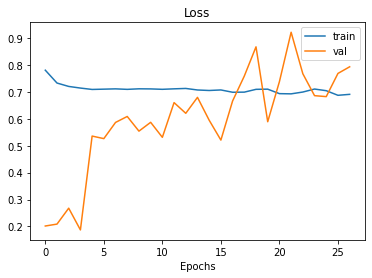

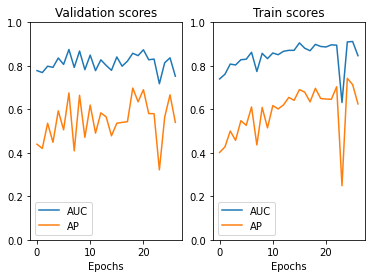

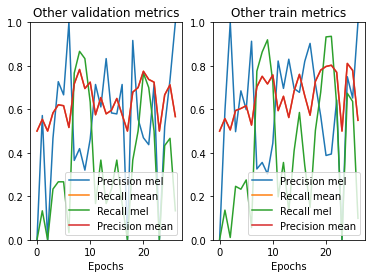

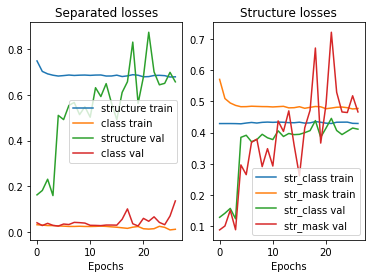

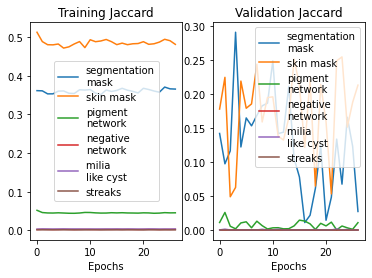

Best classification epoch:6
AUC_train:0.8623701745038841
AP_train:0.610870869555195
AUC_val:0.8752777777777778
AP_val:0.6754094333478513
Jaccard score train:[0.35482147336006165, 0.4748784005641937, 0.04438582807779312, 0.002611615229398012, 0.0036208645906299353, 0.00146860268432647]
Jaccard score val:[0.15344145894050598, 0.18575049936771393, 0.0031721030827611685, 0.0, 0.0, 0.0]
Jaccard mean score train:0.14696446408440048
Jaccard mean score val:0.057060676898496844

Best jaccard epoch:10
AUC_train:0.859059994343259
AP_train:0.6171819969447914
AUC_val:0.8494444444444444
AP_val:0.6195922341859883
Jaccard score train:[0.3642691969871521, 0.49325716495513916, 0.04635995626449585, 0.0025341317523270845, 0.00363868847489357, 0.0015280882362276316]
Jaccard score val:[0.2491561621427536, 0.1961888074874878, 0.003069730242714286, 0.0, 0.0, 0.0]
Jaccard mean score train:0.15193120444503924
Jaccard mean score val:0.07473578331215928

Best global epoch:6
AUC_train:0.8623701745038841
AP_train:0

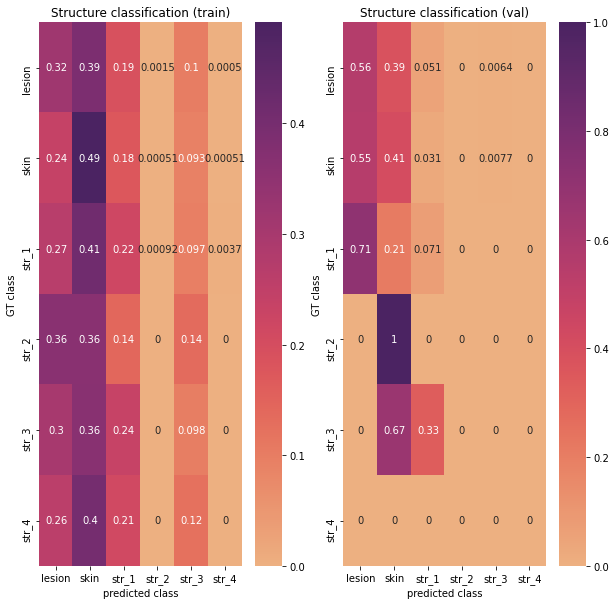


VGG_16 + Att + ConvLSTM + Deco + Classifier_GAP arquitecture ...
Best classification epoch:6
AUC_train:0.8623701745038841AP_train:0.610870869555195
AUC_val:0.8752777777777778AP_val:0.6754094333478513
Jaccard score train:[0.35482147336006165, 0.4748784005641937, 0.04438582807779312, 0.002611615229398012, 0.0036208645906299353, 0.00146860268432647]
Jaccard score val:[0.15344145894050598, 0.18575049936771393, 0.0031721030827611685, 0.0, 0.0, 0.0]
Jaccard mean score train:0.14696446408440048
Jaccard mean score val:0.057060676898496844

Best jaccard epoch:10
AUC_train:0.859059994343259
AP_train:0.6171819969447914
AUC_val:0.8494444444444444
AP_val:0.6195922341859883
Jaccard score train:[0.3642691969871521, 0.49325716495513916, 0.04635995626449585, 0.0025341317523270845, 0.00363868847489357, 0.0015280882362276316]
Jaccard score val:[0.2491561621427536, 0.1961888074874878, 0.003069730242714286, 0.0, 0.0, 0.0]
Jaccard mean score train:0.15193120444503924
Jaccard mean score val:0.07473578331215

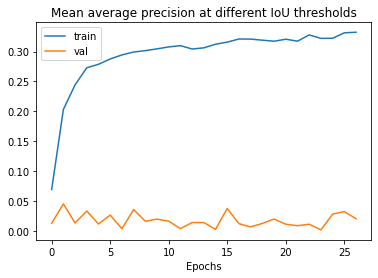

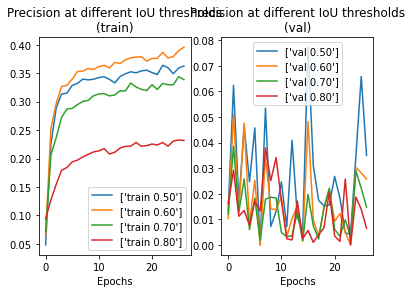

In [13]:
prueba = "/m3_complete"
th_MAP = np.arange(0.5,0.8,0.1) # list of mean prec IoU score
batch_size = 8

file = prueba
print('#########################################################################################################')
print('#########################################################################################################')
print(file)
opt = EasyDict({
    "file": file,
    "enable_decoder": 1,
    "enable_classifier": 1,
    "t": 5,
    "num_structs": 6,
    "global_path": global_path,
    "model": 5,
    "th_scores": th_MAP,
    "ch_name": ""
})
path, out_files = get_dirs(opt)
idx_class, idx_deco, idx = eval_curves(opt, checkpoint_name='lists'+ opt.ch_name + '.pth')
best_scores(opt,checkpoint_name='lists'+ opt.ch_name + '.pth')
paint_MAP_IoU (out_files, opt.num_structs, opt.th_scores, checkpoint_name='lists'+ opt.ch_name + '.pth')

## Test results

In [44]:
opt = EasyDict({
    "checkpoint_to_load": 15,#idx_class,
    "vis": 0,
    "data_loading": 3,
    "num_min_str": 30,
    "step_image": 1,
    "iters_visualization": 10,
    "enable_scheduler": 0,
    "enable_multi_lr": 1,
    "optimizer": 'Adam', #'SGD'm 'RMS', 'Adam', 'Adadelta'
    "preprocess": False,#True,
    "structures_weights": str_weights,
    "iou_weight": iou_w,
    "class_weight": 1-iou_w,
    "str_mul": str_mul,
    "class_mul": 1-str_mul,
    "att_block": 3,
    "enable_classifier": 1,
    "enable_decoder": 1,
    "db": 1, 
    "batch_size": batch_size,
    "first_epoch": 15, 
    "epochs": total_epochs,
    "global_path": global_path,
    "over_sample": False,
    "threshold": 0.5,
    "th_scores": th_MAP, # list of mean prec IoU score
    "train_val_test": -1, 
    "file": "/" + model,
    "ch_name": "", 
    "frozen": False,
    ## Architecture 
    "model": 5, 
    "t": 5,
    "num_structs": 6,
    "bn": True,
    "skip": True,
    ###
    "lr": 10**(-4),
    # VGG_AttConvLSTM_Deco_Class
    "lr_encoder": 0,
    "lr_decoder": 10**(-4),
    "lr_classifier": 10**(-4),
    "lr_attconv": lr_attconv,
    "weight_decay": 10**(-6)
})

# TRAIN
test_fun(opt)

Output hidden; open in https://colab.research.google.com to view.

In [14]:
opt = EasyDict({
    "checkpoint_to_load": 15,#idx_class,
    "vis": 0,
    "data_loading": 3,
    "num_min_str": 30,
    "step_image": 1,
    "iters_visualization": 10,
    "enable_scheduler": 0,
    "enable_multi_lr": 1,
    "optimizer": 'Adam', #'SGD'm 'RMS', 'Adam', 'Adadelta'
    "preprocess": False,#True,
    "structures_weights": str_weights,
    "iou_weight": iou_w,
    "class_weight": 1-iou_w,
    "str_mul": str_mul,
    "class_mul": 1-str_mul,
    "att_block": 3,
    "enable_classifier": 1,
    "enable_decoder": 1,
    "db": 1, 
    "batch_size": batch_size,
    "first_epoch": 15, 
    "epochs": total_epochs,
    "global_path": global_path,
    "over_sample": False,
    "threshold": 0.5,
    "th_scores": th_MAP, # list of mean prec IoU score
    "train_val_test": -1, 
    "file": "/" + model,
    "ch_name": "", 
    "frozen": False,
    ## Architecture 
    "model": 5, 
    "t": 5,
    "num_structs": 6,
    "bn": True,
    "skip": True,
    ###
    "lr": 10**(-4),
    # VGG_AttConvLSTM_Deco_Class
    "lr_encoder": 0,
    "lr_decoder": 10**(-4),
    "lr_classifier": 10**(-4),
    "lr_attconv": lr_attconv,
    "weight_decay": 10**(-6)
})

# TRAIN
test_fun(opt)

Output hidden; open in https://colab.research.google.com to view.